In [41]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [29]:
def interpolate_columns_with_year_month(df):
    df=df.copy()
    df.index = pd.to_datetime(df.index)
    
    # Apply interpolation logic to each column
    for column in df.columns:
        # Fill within the same year and month for each column
        yearly_monthly_hourly_avg = df.groupby([df.index.year, df.index.month, df.index.hour])[column].transform('mean')
        df[column].fillna(yearly_monthly_hourly_avg, inplace=True)
        
        # Check and fill any remaining NaNs in the column
        if df[column].isna().any():
            # Calculate the overall hourly average for the column as a fallback
            overall_hourly_avg = df.groupby(df.index.hour)[column].transform('mean')
            
            for time, _ in df[df[column].isna()].iterrows():
                df.at[time, column] = overall_hourly_avg[time.hour]
    
    return df

In [364]:
#upload the pickle object to the notebook
colchester_df = pd.read_pickle("colchester_cleaned_var.pkl")
#drop solarradiation,solarenergy, uvindex columns due to nulls and windpower because we will model it later
colchester_df = colchester_df.drop(['solarradiation','solarenergy','uvindex','windpower'], axis=1)

# Use only data from 2000-01-01 to 2022-11-31 for the train, for validation use data from 2022-12-01 to 2022-12-31 and for test from 2023-01-01 to 2024-01-05
train = colchester_df.loc['2018-01-01':'2023-12-30']
validation = colchester_df.loc['2023-12-31']
test = colchester_df.loc['2024-01-01':'2024-01-05']

In [21]:
#upload the pickle object to the notebook
colchester_df = pd.read_pickle("colchester_cleaned.pkl")
#leave only windpower column


# Use only data from 2000-01-01 to 2022-11-31 for the train, for validation use data from 2022-12-01 to 2022-12-31 and for test from 2023-01-01 to 2024-01-05
train = colchester_df.loc['2000-01-01':'2022-12-30']
validation = colchester_df.loc['2022-12-31']
test = colchester_df.loc['2023-01-01':'2024-01-05']

In [31]:
def process_data(data):
    df = data.copy()
    #convert index to datetime
    df.index = pd.to_datetime(df.index)
    duplicate_labels = df.index.duplicated()
    df = df[~duplicate_labels]
    df = df.resample('H').mean()
    df = df.reindex(pd.date_range(start=data.index.min(), end=data.index.max(), freq='H'))
    interpolation = interpolate_columns_with_year_month(df)
    return interpolation

In [365]:
train = process_data(train)
train.head()

temp  dew  humidity  precip  precipprob  snow  snowdepth  \
2018-01-01 00:00:00   6.8  3.7     81.03   0.154       100.0   0.0        0.0   
2018-01-01 01:00:00   6.0  3.6     84.73   0.000         0.0   0.0        0.0   
2018-01-01 02:00:00   5.6  3.1     83.73   0.000         0.0   0.0        0.0   
2018-01-01 03:00:00   5.2  2.6     83.52   0.000         0.0   0.0        0.0   
2018-01-01 04:00:00   4.9  2.6     85.04   0.000         0.0   0.0        0.0   

                     windspeed  winddir  sealevelpressure  cloudcover  \
2018-01-01 00:00:00       36.9    269.0             994.9        77.7   
2018-01-01 01:00:00       31.5    262.0             996.0        40.5   
2018-01-01 02:00:00       29.9    257.0             997.1        16.1   
2018-01-01 03:00:00       26.3    249.0             997.7        22.8   
2018-01-01 04:00:00       24.9    242.0             997.7        17.1   

                     preciptype_rain  preciptype_snow  
2018-01-01 00:00:00              1.0              0.0  
2018-01-01 01:00:00              0.0              0.0  
2018-01-01 02:00:00              0.0              0.0  
2018-01-01 03:00:00              0.0              0.0  
2018-01-01 04:00:00              0.0              0.0

In [366]:
validation = process_data(validation)
validation.head()

temp  dew  humidity  precip  precipprob  snow  snowdepth  \
2023-12-31 00:00:00  10.5  8.2     85.69     0.1       100.0   0.0        0.0   
2023-12-31 01:00:00  10.7  8.0     83.81     0.0         0.0   0.0        0.0   
2023-12-31 02:00:00  10.5  7.2     79.94     0.7       100.0   0.0        0.0   
2023-12-31 03:00:00   8.2  6.4     88.39     2.7       100.0   0.0        0.0   
2023-12-31 04:00:00   7.8  6.0     88.35     2.6       100.0   0.0        0.0   

                     windspeed  winddir  sealevelpressure  cloudcover  \
2023-12-31 00:00:00       34.8    172.0             991.4        97.4   
2023-12-31 01:00:00       34.7    172.0             990.1        91.0   
2023-12-31 02:00:00       32.7    188.0             988.7        95.1   
2023-12-31 03:00:00       28.6    198.0             987.8        98.7   
2023-12-31 04:00:00       23.0    182.0             986.9        97.4   

                     preciptype_rain  preciptype_snow  
2023-12-31 00:00:00              1.0              0.0  
2023-12-31 01:00:00              1.0              0.0  
2023-12-31 02:00:00              1.0              0.0  
2023-12-31 03:00:00              1.0              0.0  
2023-12-31 04:00:00              1.0              0.0

In [367]:
test = process_data(test)
test.head()

temp  dew  humidity  precip  precipprob  snow  snowdepth  \
2024-01-01 00:00:00   7.9  4.9     81.46     0.0         0.0   0.0        0.0   
2024-01-01 01:00:00   7.5  5.0     84.33     0.0         0.0   0.0        0.0   
2024-01-01 02:00:00   7.8  4.4     79.12     0.0         0.0   0.0        0.0   
2024-01-01 03:00:00   7.4  3.6     77.22     0.0         0.0   0.0        0.0   
2024-01-01 04:00:00   7.3  3.9     78.79     0.0         0.0   0.0        0.0   

                     windspeed  winddir  sealevelpressure  cloudcover  \
2024-01-01 00:00:00       32.2    240.0             993.1        97.5   
2024-01-01 01:00:00       29.3    246.0             993.1       100.0   
2024-01-01 02:00:00       31.0    248.0             994.1        97.2   
2024-01-01 03:00:00       31.6    247.0             994.8        41.7   
2024-01-01 04:00:00       31.3    254.0             996.2        78.1   

                     preciptype_rain  preciptype_snow  
2024-01-01 00:00:00              1.0              0.0  
2024-01-01 01:00:00              0.0              0.0  
2024-01-01 02:00:00              0.0              0.0  
2024-01-01 03:00:00              0.0              0.0  
2024-01-01 04:00:00              0.0              0.0

In [43]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
#since the test works for only 12 variables, I have randomly dropped
#in the next iteration, I would drop another and check the eigenvalues
johan_test = train.drop([ 'snowdepth'], axis=1)
# Perform the Johansen Cointegration Test with a specified number of zero
specified_number = 0  # Testing for zero cointegrating relationships
coint_test_result = coint_johansen(johan_test,specified_number,1)

In [44]:
# Extract the trace statistics and eigen statistics
trace_stats = coint_test_result.lr1
eigen_stats = coint_test_result.lr2

# Print the test results
print("Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):")
print(f"Trace Statistics: {coint_test_result.lr1}")
print(f"Critical Values: {coint_test_result.cvt}")

Johansen Cointegration Test Results (Testing for Zero Cointegrating Relationships):
Trace Statistics: [94176.70671025 72671.49468495 56366.54932899 41129.69147369
 28628.04268798 17680.29140092 12150.49282817  7798.17096495
  4537.24186308  1956.1029228    437.03802062   125.84248367]
Critical Values: [[326.5354 334.9795 351.215 ]
 [277.374  285.1402 300.2821]
 [232.103  239.2468 253.2526]
 [190.8714 197.3772 210.0366]
 [153.6341 159.529  171.0905]
 [120.3673 125.6185 135.9825]
 [ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]


In [45]:
# print confidence level for critical values
print("Critical Values at 90% Confidence Level:")
print(coint_test_result.cvm)


Critical Values at 90% Confidence Level:
[[73.0563 76.5734 83.7105]
 [67.1307 70.5392 77.4877]
 [61.2041 64.504  71.2525]
 [55.2412 58.4332 64.996 ]
 [49.2855 52.3622 58.6634]
 [43.2947 46.2299 52.3069]
 [37.2786 40.0763 45.8662]
 [31.2379 33.8777 39.3693]
 [25.1236 27.5858 32.7172]
 [18.8928 21.1314 25.865 ]
 [12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


cointegration in all except variables

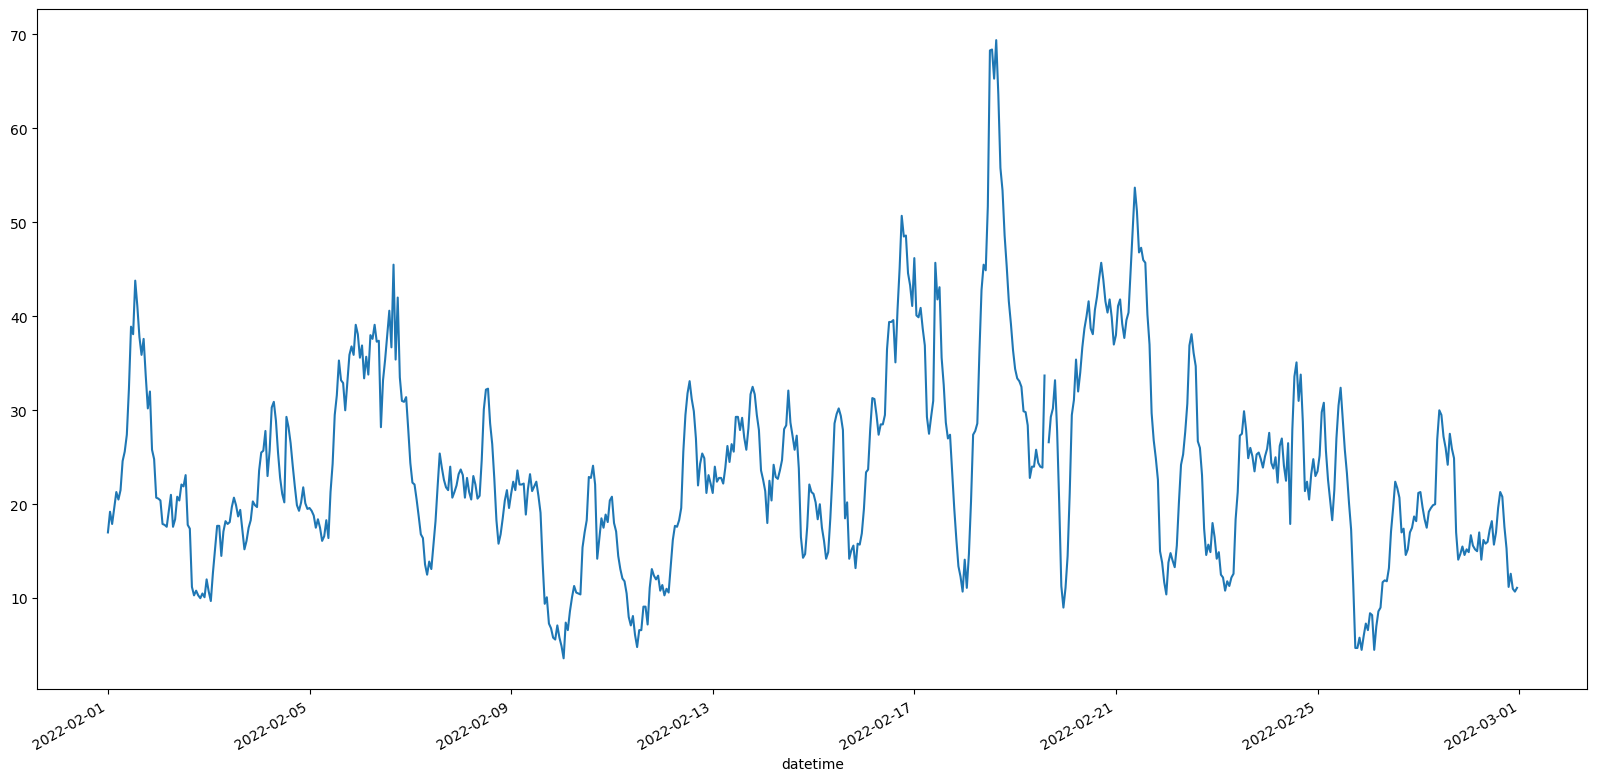

In [22]:
train['windspeed']['2022-02-01':'2022-02-28'].plot()
#change size of the plot
plt.gcf().set_size_inches(20, 10)

plt.show()

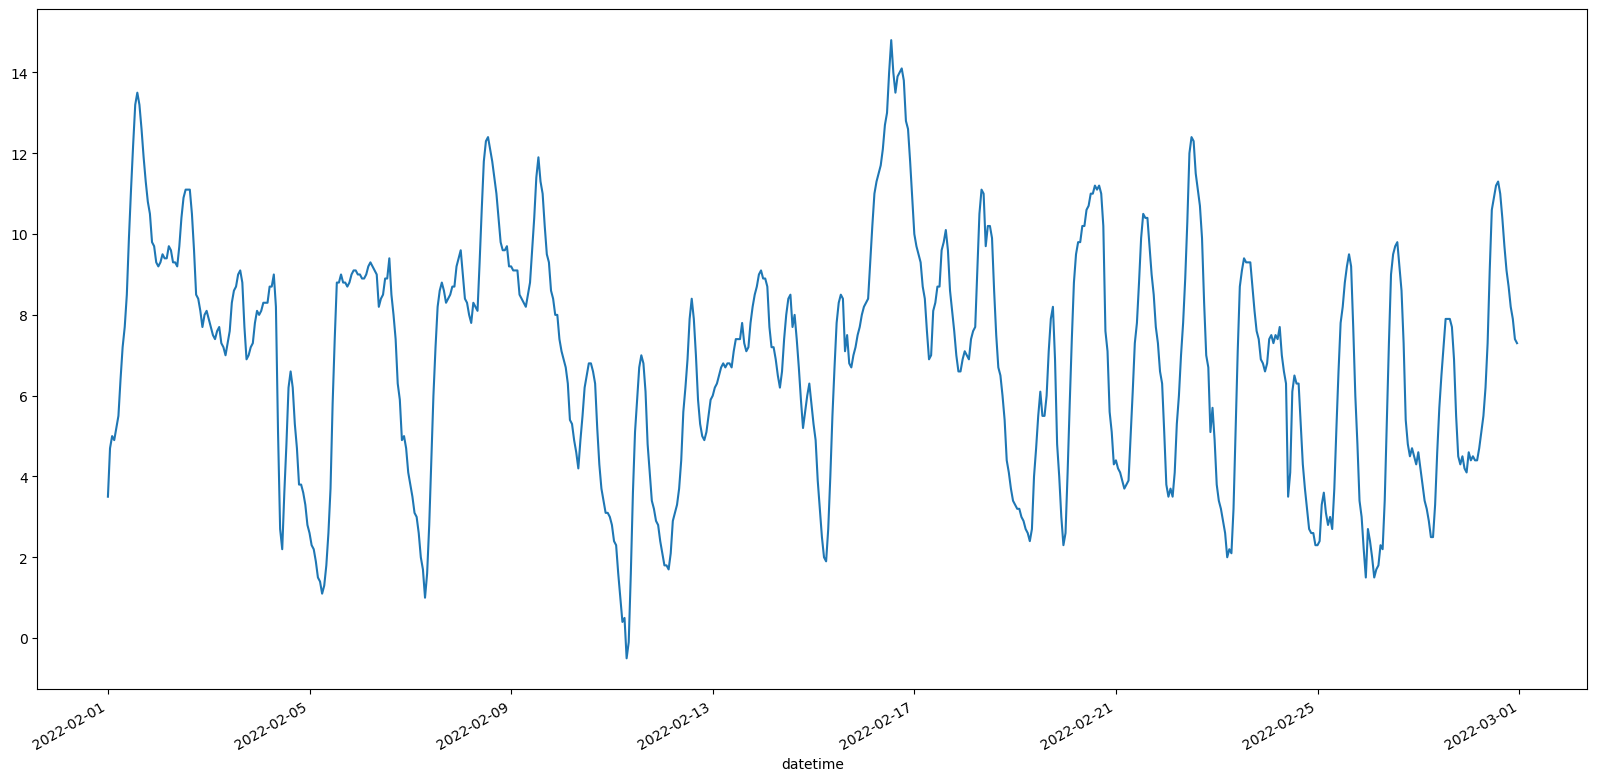

In [23]:
train['temp']['2022-02-01':'2022-02-28'].plot()
#change size of the plot
plt.gcf().set_size_inches(20, 10)

plt.show()

## Baseline model

In [9]:
import matplotlib.pyplot as plt

In [24]:
def measure_forecast_error(label, forecast):
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f (W)' % mean_absolute_error(label, forecast))
    print('MAPE = %.2f%%' % (100*mean_absolute_percentage_error(label, forecast)))
    print('R2 = %.2f' % r2_score(label, forecast))

In [26]:
train.windspeed.iloc[len(train)-len(validation):]

datetime
2022-12-30 00:00:00    18.0
2022-12-30 01:00:00    16.8
2022-12-30 02:00:00    12.6
2022-12-30 03:00:00    17.1
2022-12-30 04:00:00    20.8
2022-12-30 05:00:00    21.3
2022-12-30 06:00:00    22.1
2022-12-30 07:00:00    25.7
2022-12-30 08:00:00    27.9
2022-12-30 09:00:00    26.4
2022-12-30 10:00:00    30.6
2022-12-30 11:00:00    33.8
2022-12-30 12:00:00    31.2
2022-12-30 13:00:00    27.3
2022-12-30 14:00:00    29.4
2022-12-30 15:00:00    30.7
2022-12-30 16:00:00    31.4
2022-12-30 17:00:00    29.6
2022-12-30 18:00:00    27.1
2022-12-30 19:00:00    24.6
2022-12-30 20:00:00    22.6
2022-12-30 21:00:00    23.2
2022-12-30 22:00:00    17.7
2022-12-30 23:00:00    17.7
Name: windspeed, dtype: float64

MAE = 5.58 (W)
MAPE = 20.08%
R2 = 0.15


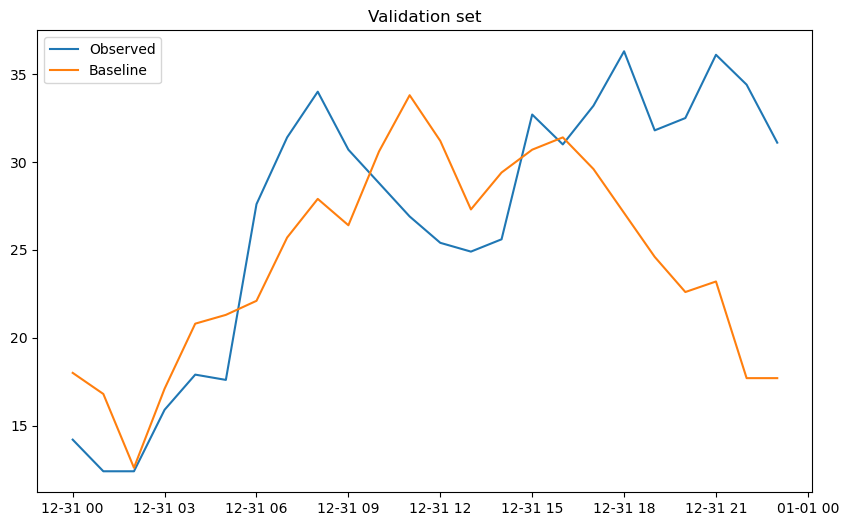

In [27]:
#use last period of train as prediction to compare with validation

validation['baseline'] = train.windspeed.iloc[len(train)-len(validation):].values
measure_forecast_error(validation['windspeed'], validation['baseline'])

#plot the validation and the baseline

plt.figure(figsize=(10, 6))
plt.plot(validation.index, validation['windspeed'], label='Observed')
plt.plot(validation.index, validation['baseline'], label='Baseline')
plt.title('Validation set')
plt.legend()
plt.show()

MAE = 1282940.08 (W)
MAPE = 26.47%
R2 = 0.58


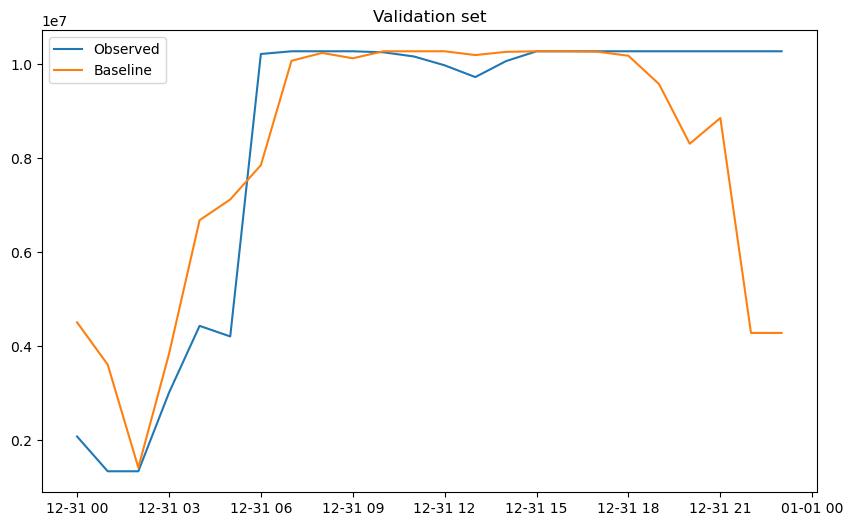

In [10]:
#use last period of train as prediction to compare with validation

validation['baseline'] = train.iloc[len(train)-len(validation):].values
measure_forecast_error(validation['windpower'], validation['baseline'])

#plot the validation and the baseline

plt.figure(figsize=(10, 6))
plt.plot(validation.index, validation['windpower'], label='Observed')
plt.plot(validation.index, validation['baseline'], label='Baseline')
plt.title('Validation set')
plt.legend()
plt.show()


## Statistical model

In [368]:
#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit(maxlags=15, ic='aic')

In [369]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Mar, 2024
Time:                     20:42:51
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                   -5.86837
Nobs:                     52545.0    HQIC:                  -6.16405
Log likelihood:          -801231.    FPE:                 0.00183913
AIC:                     -6.29846    Det(Omega_mle):      0.00175224
--------------------------------------------------------------------
Results for equation temp
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.643928         0.353003            1.824           0.068
L1.temp                      1.155572         0.008639          133.758           0.000
L1.dew                       0.31

In [370]:

# make prediction on validation
prediction = model_fit.forecast(train.values, steps=len(validation))

In [371]:
#missing value treatment
cols = train.columns

In [53]:
#import sqrt and mean_squared_error 
from math import sqrt
from sklearn.metrics import mean_squared_error

In [372]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse

for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], validation[i])))

rmse value for temp is :  1.4887658248977882
rmse value for dew is :  1.1960256642878386
rmse value for humidity is :  3.584303380120305
rmse value for precip is :  0.7340328948413111
rmse value for precipprob is :  45.6767787364781
rmse value for snow is :  0.005189850916794036
rmse value for snowdepth is :  0.11221814011098309
rmse value for windspeed is :  6.958688799877799
rmse value for winddir is :  36.33748107753259
rmse value for sealevelpressure is :  5.517089262652188
rmse value for cloudcover is :  18.097959933689637
rmse value for preciptype_rain is :  0.47399997074347033
rmse value for preciptype_snow is :  0.007302261058014847


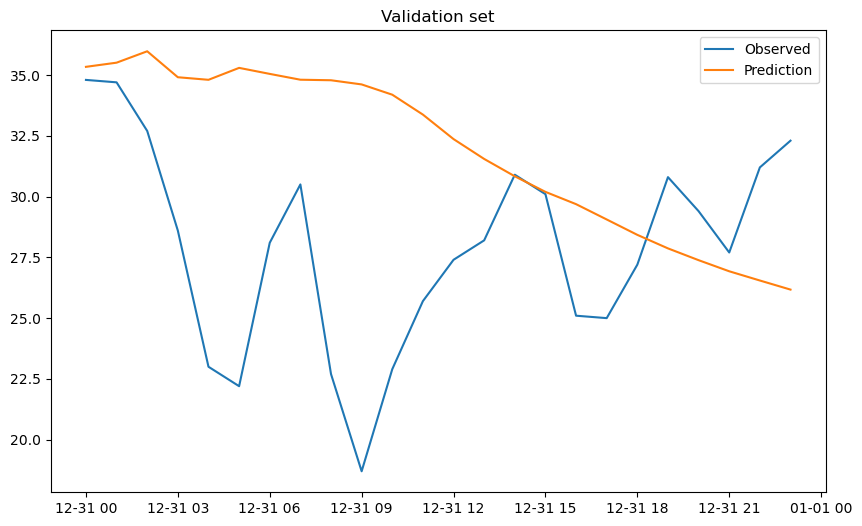

In [373]:
#plot the validation and the prediction for windspeed, temp and sealvlpressure

plt.figure(figsize=(10, 6))
plt.plot(validation.index, validation['windspeed'], label='Observed')
plt.plot(validation.index, pred['windspeed'], label='Prediction')
plt.title('Validation set')
plt.legend()
plt.show()


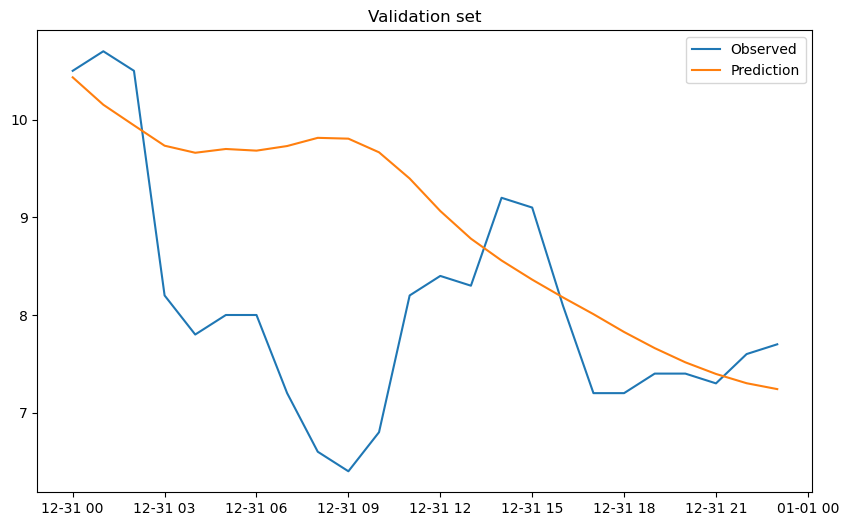

In [374]:
plt.figure(figsize=(10, 6))
plt.plot(validation.index, validation['temp'], label='Observed')
plt.plot(validation.index, pred['temp'], label='Prediction')
plt.title('Validation set')
plt.legend()
plt.show()

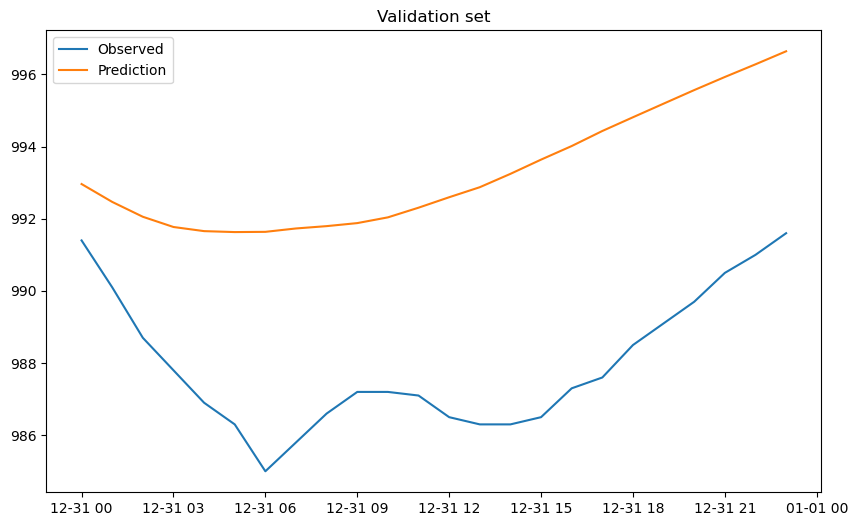

In [375]:
plt.figure(figsize=(10, 6))
plt.plot(validation.index, validation['sealevelpressure'], label='Observed')
plt.plot(validation.index, pred['sealevelpressure'], label='Prediction')
plt.title('Validation set')
plt.legend()
plt.show()

In [376]:
#predict on the test set
prediction = model_fit.forecast(validation.values, steps=len(test))


In [378]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse

for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], test[i])))

rmse value for temp is :  3.267338895878062
rmse value for dew is :  3.7245372021913425
rmse value for humidity is :  5.812604201819792
rmse value for precip is :  1.1151131496296398
rmse value for precipprob is :  45.5592938354208
rmse value for snow is :  0.0017202207406041981
rmse value for snowdepth is :  0.11245185934367298
rmse value for windspeed is :  8.82382525435052
rmse value for winddir is :  64.24068866985266
rmse value for sealevelpressure is :  16.182230383614563
rmse value for cloudcover is :  31.36695847840439
rmse value for preciptype_rain is :  0.5536096531087613
rmse value for preciptype_snow is :  0.008609163049443794


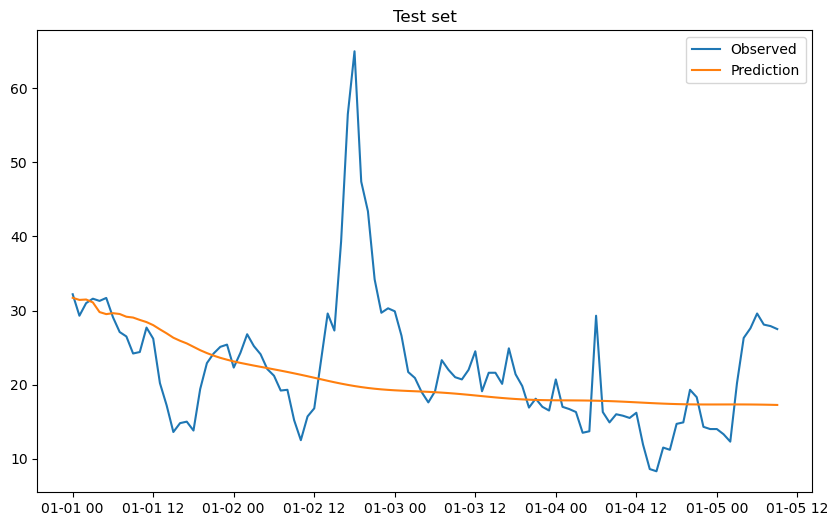

In [380]:
#plot the validation and the prediction for windspeed, temp and sealvlpressure

plt.figure(figsize=(10, 6))
plt.plot(test.index, test['windspeed'], label='Observed')
plt.plot(test.index, pred['windspeed'], label='Prediction')
plt.title('Test set')
plt.legend()
plt.show()

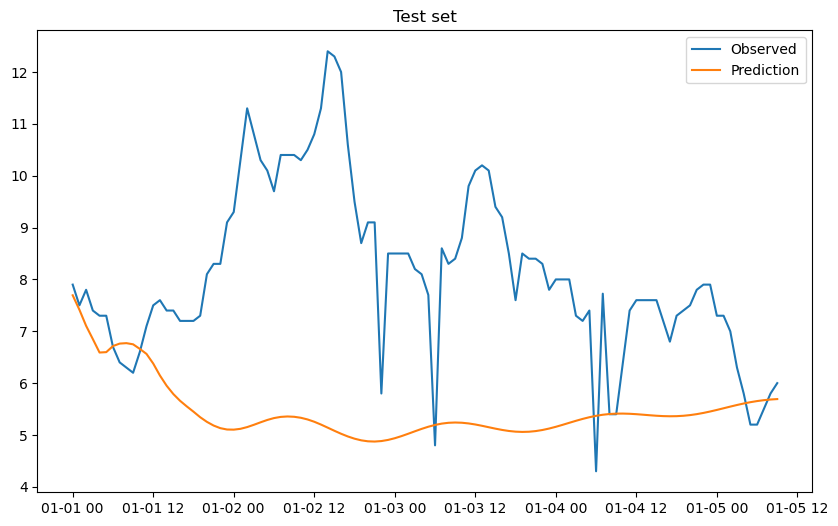

In [381]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['temp'], label='Observed')
plt.plot(test.index, pred['temp'], label='Prediction')
plt.title('Test set')
plt.legend()
plt.show()

In [8]:
#use just last year for SARIMA model
sarima_train = train.loc['2021-01-01':'2022-12-30']

In [18]:
import pmdarima as pmd
model=pmd.auto_arima(sarima_train['windpower'],start_p=0,start_q=0,test='adf',m=24,seasonal=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=570843.248, Time=23.25 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=573305.418, Time=0.77 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=533221.102, Time=17.93 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=560988.083, Time=13.14 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=586083.630, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=533899.213, Time=0.94 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=532824.953, Time=95.12 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=532782.245, Time=149.19 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=532988.096, Time=28.55 sec
 ARIMA(1,0,0)(2,0,2)[24] intercept   : AIC=inf, Time=247.88 sec
 ARIMA(1,0,0)(1,0,2)[24] intercept   : AIC=532842.503, Time=121.86 sec
 ARIMA(0,0,0)(2,0,1)[24] intercept   : AIC=569885.023, Time=135.13 sec
 ARIMA(2,0,0)(2,0,1)[24] intercept   : AIC=532667.821, Time=179.90 sec
 ARIMA(2,0,0)(1,0,1)[24] intercept   : AIC=532861.60

: 

In [ ]:
#best ARIMA(2,0,0)(2,0,1)[24] model

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

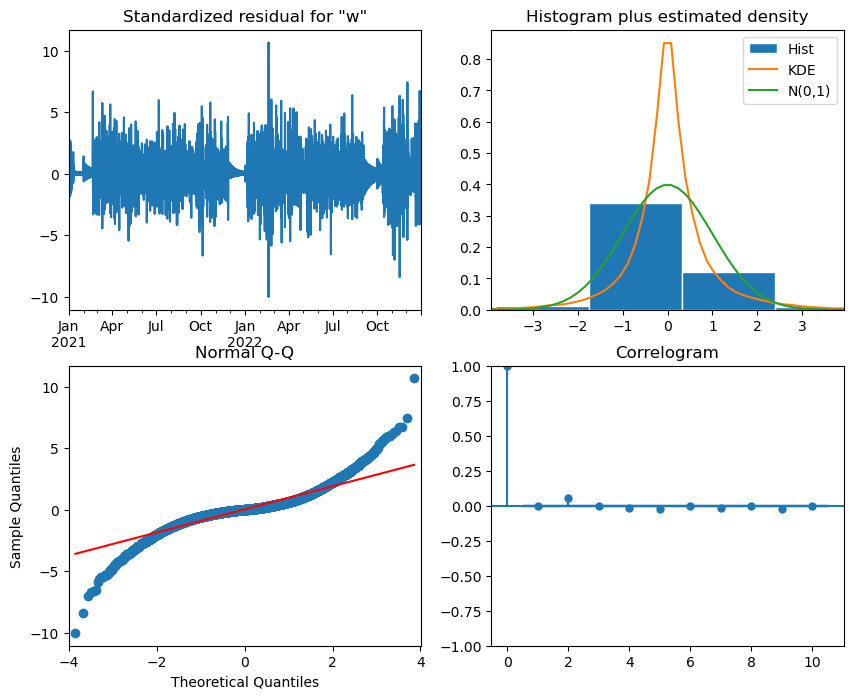

In [13]:
#build a SARIMA model

# Define the model
model = SARIMAX(sarima_train['windpower'], order=(2, 0, 0), seasonal_order=(2, 0, 1, 24), simple_differencing=False).fit(disp=False)
_=model.plot_diagnostics(figsize=(10,8))

In [14]:
#forecast the validation set
validation['sarima'] = model.get_forecast(len(validation)).predicted_mean
measure_forecast_error(validation['windpower'], validation['sarima'])

MAE = 4851554.55 (W)
MAPE = 65.56%
R2 = -1.56


Not a good model

## Deep Learning

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet

from neuralforecast.losses.numpy import mae, mse

In [18]:
horizon = 24

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         TimesNet(h=horizon,
                 input_size=2*horizon,
                 max_steps=50)]

Seed set to 1
Seed set to 1
Seed set to 1


In [19]:
nf = NeuralForecast(models=models, freq='H')

In [29]:
#join train and validation to train the model
train_validation = pd.concat([train, validation])
# create unique_id column
train_validation['unique_id'] = 'CO'
# reset index and name the column as ds


In [30]:
train_validation = train_validation.reset_index()
train_validation = train_validation.rename(columns={'index':'ds', 'windpower':'y'})
#drop baseline and sarima columns
train_validation = train_validation.drop(columns=['baseline', 'sarima'])
train_validation.head()

ds             y unique_id
0 2000-01-01 00:00:00  4.901388e+05        CO
1 2000-01-01 01:00:00  2.570771e+06        CO
2 2000-01-01 02:00:00  1.921775e+06        CO
3 2000-01-01 03:00:00  2.023435e+06        CO
4 2000-01-01 04:00:00  2.132902e+06        CO

In [31]:
preds_df = nf.cross_validation(df=train_validation, step_size=horizon, n_windows=2)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-03-17 22:19:34.432435: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [32]:
preds_df

unique_id                  ds              cutoff      NHITS      NBEATS  \
0         CO 2022-12-30 00:00:00 2022-12-29 23:00:00  4403325.5  4426274.00   
1         CO 2022-12-30 01:00:00 2022-12-29 23:00:00  4427034.0  4493863.00   
2         CO 2022-12-30 02:00:00 2022-12-29 23:00:00  4381328.5  4123902.25   
3         CO 2022-12-30 03:00:00 2022-12-29 23:00:00  4356871.0  4273798.50   
4         CO 2022-12-30 04:00:00 2022-12-29 23:00:00  4436836.5  4171856.50   
5         CO 2022-12-30 05:00:00 2022-12-29 23:00:00  4279759.0  4154576.75   
6         CO 2022-12-30 06:00:00 2022-12-29 23:00:00  4340503.0  4332444.50   
7         CO 2022-12-30 07:00:00 2022-12-29 23:00:00  4310607.0  4074955.00   
8         CO 2022-12-30 08:00:00 2022-12-29 23:00:00  4415862.5  4230609.00   
9         CO 2022-12-30 09:00:00 2022-12-29 23:00:00  4741159.0  4572831.00   
10        CO 2022-12-30 10:00:00 2022-12-29 23:00:00  5092740.5  5024634.00   
11        CO 2022-12-30 11:00:00 2022-12-29 23:00:00  5575642.0  5480111.00   
12        CO 2022-12-30 12:00:00 2022-12-29 23:00:00  5937712.5  6052148.00   
13        CO 2022-12-30 13:00:00 2022-12-29 23:00:00  6166597.0  6321992.00   
14        CO 2022-12-30 14:00:00 2022-12-29 23:00:00  6571968.0  6712776.00   
15        CO 2022-12-30 15:00:00 2022-12-29 23:00:00  6648338.0  6893014.00   
16        CO 2022-12-30 16:00:00 2022-12-29 23:00:00  6660349.5  7010572.00   
17        CO 2022-12-30 17:00:00 2022-12-29 23:00:00  6719841.0  7028513.50   
18        CO 2022-12-30 18:00:00 2022-12-29 23:00:00  6687972.0  6769794.00   
19        CO 2022-12-30 19:00:00 2022-12-29 23:00:00  6372572.0  6315902.50   
20        CO 2022-12-30 20:00:00 2022-12-29 23:00:00  5970747.0  5750202.00   
21        CO 2022-12-30 21:00:00 2022-12-29 23:00:00  5579095.0  5315427.00   
22        CO 2022-12-30 22:00:00 2022-12-29 23:00:00  5235539.5  5118178.00   
23        CO 2022-12-30 23:00:00 2022-12-29 23:00:00  5050847.0  5123610.50   
24        CO 2022-12-31 00:00:00 2022-12-30 23:00:00  4208738.5  4060513.75   
25        CO 2022-12-31 01:00:00 2022-12-30 23:00:00  4283946.0  4017688.25   
26        CO 2022-12-31 02:00:00 2022-12-30 23:00:00  4320105.5  4008118.00   
27        CO 2022-12-31 03:00:00 2022-12-30 23:00:00  4292497.0  3944851.00   
28        CO 2022-12-31 04:00:00 2022-12-30 23:00:00  4517039.5  4438069.50   
29        CO 2022-12-31 05:00:00 2022-12-30 23:00:00  4480598.5  4413946.50   
30        CO 2022-12-31 06:00:00 2022-12-30 23:00:00  4704944.0  4833466.00   
31        CO 2022-12-31 07:00:00 2022-12-30 23:00:00  5064225.5  5136728.50   
32        CO 2022-12-31 08:00:00 2022-12-30 23:00:00  5557104.0  5617241.00   
33        CO 2022-12-31 09:00:00 2022-12-30 23:00:00  6258649.0  6039145.50   
34        CO 2022-12-31 10:00:00 2022-12-30 23:00:00  6835415.0  6591712.50   
35        CO 2022-12-31 11:00:00 2022-12-30 23:00:00  7495451.5  7262307.00   
36        CO 2022-12-31 12:00:00 2022-12-30 23:00:00  7986066.0  8029802.00   
37        CO 2022-12-31 13:00:00 2022-12-30 23:00:00  8414396.0  8803048.00   
38        CO 2022-12-31 14:00:00 2022-12-30 23:00:00  8812967.0  8703504.00   
39        CO 2022-12-31 15:00:00 2022-12-30 23:00:00  8646854.0  8637261.00   
40        CO 2022-12-31 16:00:00 2022-12-30 23:00:00  8338303.5  8796862.00   
41        CO 2022-12-31 17:00:00 2022-12-30 23:00:00  8054024.0  8054780.00   
42        CO 2022-12-31 18:00:00 2022-12-30 23:00:00  7553242.0  7455877.50   
43        CO 2022-12-31 19:00:00 2022-12-30 23:00:00  6906355.0  6740252.00   
44        CO 2022-12-31 20:00:00 2022-12-30 23:00:00  6291939.0  5942161.00   
45        CO 2022-12-31 21:00:00 2022-12-30 23:00:00  5674739.5  5363167.00   
46        CO 2022-12-31 22:00:00 2022-12-30 23:00:00  5278183.5  4851599.00   
47        CO 2022-12-31 23:00:00 2022-12-30 23:00:00  5050595.0  4855402.50   

     TimesNet             y  
0   7681285.5  4.506914e+06  
1   7589844.5  3.607520e+06  
2   7939617.0  1.415731e+06  
3   7745367

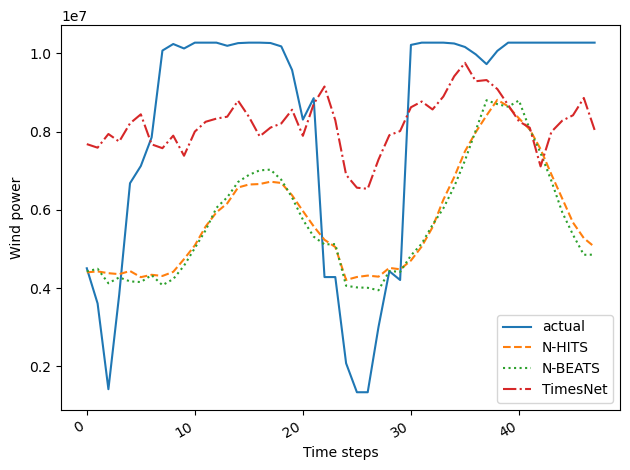

In [38]:
fig, ax = plt.subplots()

ax.plot(preds_df['y'], label='actual')
ax.plot(preds_df['NHITS'], label='N-HITS', ls='--')
ax.plot(preds_df['NBEATS'], label='N-BEATS', ls=':')
ax.plot(preds_df['TimesNet'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Wind power')

fig.autofmt_xdate()
plt.tight_layout()

In [34]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), mse(preds_df['TimesNet'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

In [35]:
measure_forecast_error(preds_df['y'], preds_df['NBEATS'])

MAE = 3065819.96 (W)
MAPE = 44.75%
R2 = -0.31


In [36]:
measure_forecast_error(preds_df['y'], preds_df['TimesNet'])

MAE = 2325859.33 (W)
MAPE = 59.58%
R2 = 0.20


In [37]:
measure_forecast_error(preds_df['y'], preds_df['NHITS'])

MAE = 3066984.01 (W)
MAPE = 46.17%
R2 = -0.28


### LSTM

In [88]:
import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

2024-03-18 15:27:23.208693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [230]:
dataset = pd.read_pickle("colchester_cleaned.pkl")
dataset = dataset['windpower'].to_frame()
# Use only data from 2000-01-01 to 2022-11-31 for the train, for validation use data from 2022-12-01 to 2022-12-31 and for test from 2023-01-01 to 2024-01-05
train_lstm = process_data(dataset.loc['2018-01-01':'2023-12-20'])
validation_lstm = process_data(dataset.loc['2023-12-20':'2023-12-31'])
test_lstm = process_data(dataset.loc['2024-01-01':'2024-01-05'])

In [171]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [231]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [232]:
train_lstm = train_lstm['windpower'].values
test_lstm = test_lstm['windpower'].values
validation_lstm = validation_lstm['windpower'].values

train_lstm = train_lstm.astype('float32')
test_lstm = test_lstm.astype('float32')
validation_lstm = validation_lstm.astype('float32')

train_lstm = np.reshape(train_lstm, (-1, 1))
test_lstm = np.reshape(test_lstm, (-1, 1))
validation_lstm = np.reshape(validation_lstm, (-1, 1))

train_lstm = scaler.fit_transform(train_lstm)
test_lstm = scaler.transform(test_lstm)
validation_lstm = scaler.transform(validation_lstm)

In [233]:
look_back = 2
X_train, Y_train = create_dataset(train_lstm, look_back)
X_test, Y_test = create_dataset(test_lstm
                                , look_back)

X_validation, Y_validation = create_dataset(validation_lstm, look_back)

In [234]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_validation = np.reshape(X_validation, (X_validation.shape[0], 1, X_validation.shape[1]))

In [235]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [236]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               67072     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [237]:
history = model.fit(X_train, Y_train, epochs=10, batch_size=20, validation_data=(X_validation, Y_validation),verbose=1, shuffle=False)

Epoch 1/10
2616/2616 [==============================] - 14s 4ms/step - loss: 0.0172 - val_loss: 0.0099
Epoch 2/10
2616/2616 [==============================] - 12s 5ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 3/10
2616/2616 [==============================] - 11s 4ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 4/10
2616/2616 [==============================] - 12s 5ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 5/10
2616/2616 [==============================] - 12s 5ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 6/10
2616/2616 [==============================] - 12s 4ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 7/10
2616/2616 [==============================] - 13s 5ms/step - loss: 0.0111 - val_loss: 0.0100
Epoch 8/10
2616/2616 [==============================] - 13s 5ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 9/10
2616/2616 [==============================] - 12s 5ms/step - loss: 0.0112 - val_loss: 0.0098
Epoch 10/10
2616/2616 [==============================] - 14s 5ms/step - l

In [238]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


4/4 [==============================] - 0s 2ms/step


In [239]:
validation_predict = model.predict(X_validation)

9/9 [==============================] - 0s 3ms/step


In [240]:
validation_predict = scaler.inverse_transform(validation_predict)
Y_validation = scaler.inverse_transform([Y_validation])

In [241]:
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 677717.2128580809
Train Root Mean Squared Error: 1079813.402203929
Test Mean Absolute Error: 1430666.0648280964
Test Root Mean Squared Error: 2437784.3798323106


In [242]:
mape_train = np.mean(np.abs((Y_train[0] - train_predict[:,0]) / Y_train[0])) * 100
mape_test = np.mean(np.abs((Y_test[0] - test_predict[:,0]) / Y_test[0])) * 100

print("Train MAPE: {}, Test MAPE: {}".format(mape_train, mape_test))

Train MAPE: inf, Test MAPE: inf


In [243]:
#calculate r2 score
r2_train = r2_score(Y_train[0], train_predict[:,0])
r2_test = r2_score(Y_test[0], test_predict[:,0])

print("Train R2: {}, Test R2: {}".format(r2_train, r2_test))


Train R2: 0.8983794314913602, Test R2: 0.48430743900757545


In [244]:
r2_validation = r2_score(Y_validation[0], validation_predict[:,0])

print("Validation R2: {}".format(r2_validation))

Validation R2: 0.860762091166128


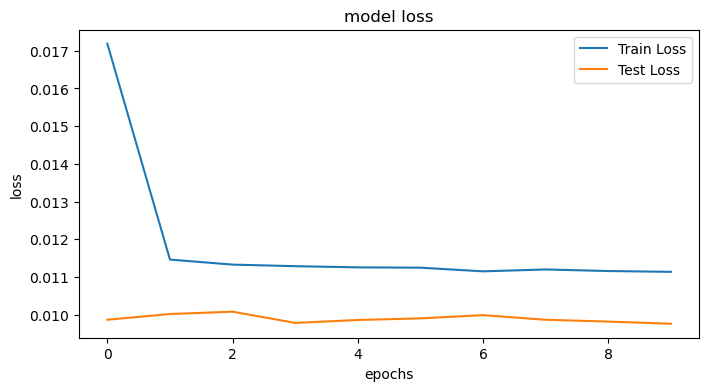

In [245]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [204]:
import seaborn as sns

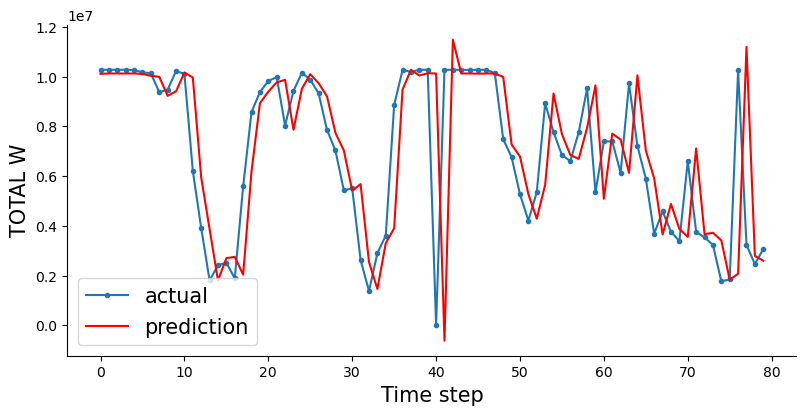

In [246]:
idx = 80
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:idx], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL W', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

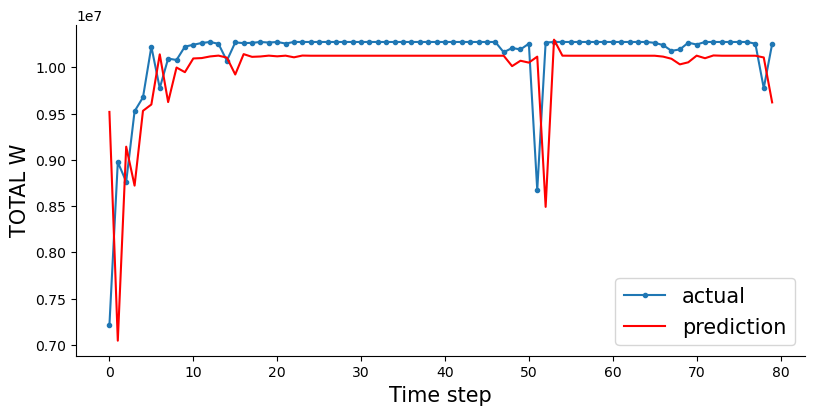

In [247]:
idx = 80
aa=[x for x in range(idx)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_validation[0][:idx], marker='.', label="actual")
plt.plot(aa, validation_predict[:,0][:idx], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('TOTAL W', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

## XGBOOST + fourier series

In [309]:
#upload the pickle object to the notebook
#FOR XGBOOST MODEL
colchester_df = pd.read_pickle("colchester_cleaned_var.pkl")
#drop solarradiation,solarenergy, uvindex columns due to nulls and windpower because we will model it later
colchester_df = colchester_df['windspeed']

# Use only data from 2000-01-01 to 2022-11-31 for the train, for validation use data from 2022-12-01 to 2022-12-31 and for test from 2023-01-01 to 2024-01-05
train = colchester_df.loc['2018-01-01':'2023-12-30'].to_frame()
validation = colchester_df.loc['2023-12-31'].to_frame()
test = colchester_df.loc['2024-01-01':'2024-01-05'].to_frame()

In [310]:
train = process_data(train)
train.head()
validation = process_data(validation)
validation.head()
test = process_data(test)
test.head()

windspeed
2024-01-01 00:00:00       32.2
2024-01-01 01:00:00       29.3
2024-01-01 02:00:00       31.0
2024-01-01 03:00:00       31.6
2024-01-01 04:00:00       31.3

In [306]:
import xgboost as xgb

In [278]:
import plotly.graph_objects as go

In [251]:
# We can add multiple fourer series with different k terms - (2*k*pi) such as k=1,2,3...etc. To generalize the problem, 
# we could have chosen an optimal k value for each season by trying out some k values and choosing the values giving 
# the lowest AIC score.
def add_fourier_terms(df, year_k, week_k, day_k):
    """
    df: dataframe to add the fourier terms to 
    year_k: the number of Fourier terms the year period should have. Thus the model will be fit on 2*year_k terms (1 term for 
            sine and 1 for cosine)
    week_k: same as year_k but for weekly periods
    day_k:  same as year_k but for daily periods
    """
    
    for k in range(1, year_k+1):
        # year has a period of 365.25 including the leap year
        df['year_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofyear/365.25) 
        df['year_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofyear/365.25)

    for k in range(1, week_k+1):
        
        # week has a period of 7
        df['week_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.dayofweek/7)
        df['week_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.dayofweek/7)


    for k in range(1, day_k+1):
        
        # day has period of 24
        df['hour_sin'+str(k)] = np.sin(2 *k* np.pi * df.index.hour/24)
        df['hour_cos'+str(k)] = np.cos(2 *k* np.pi * df.index.hour/24) 

In [311]:
add_fourier_terms(train, year_k= 2, week_k=2 , day_k=2)

In [312]:
add_fourier_terms(validation, year_k= 2, week_k=2 , day_k=2)

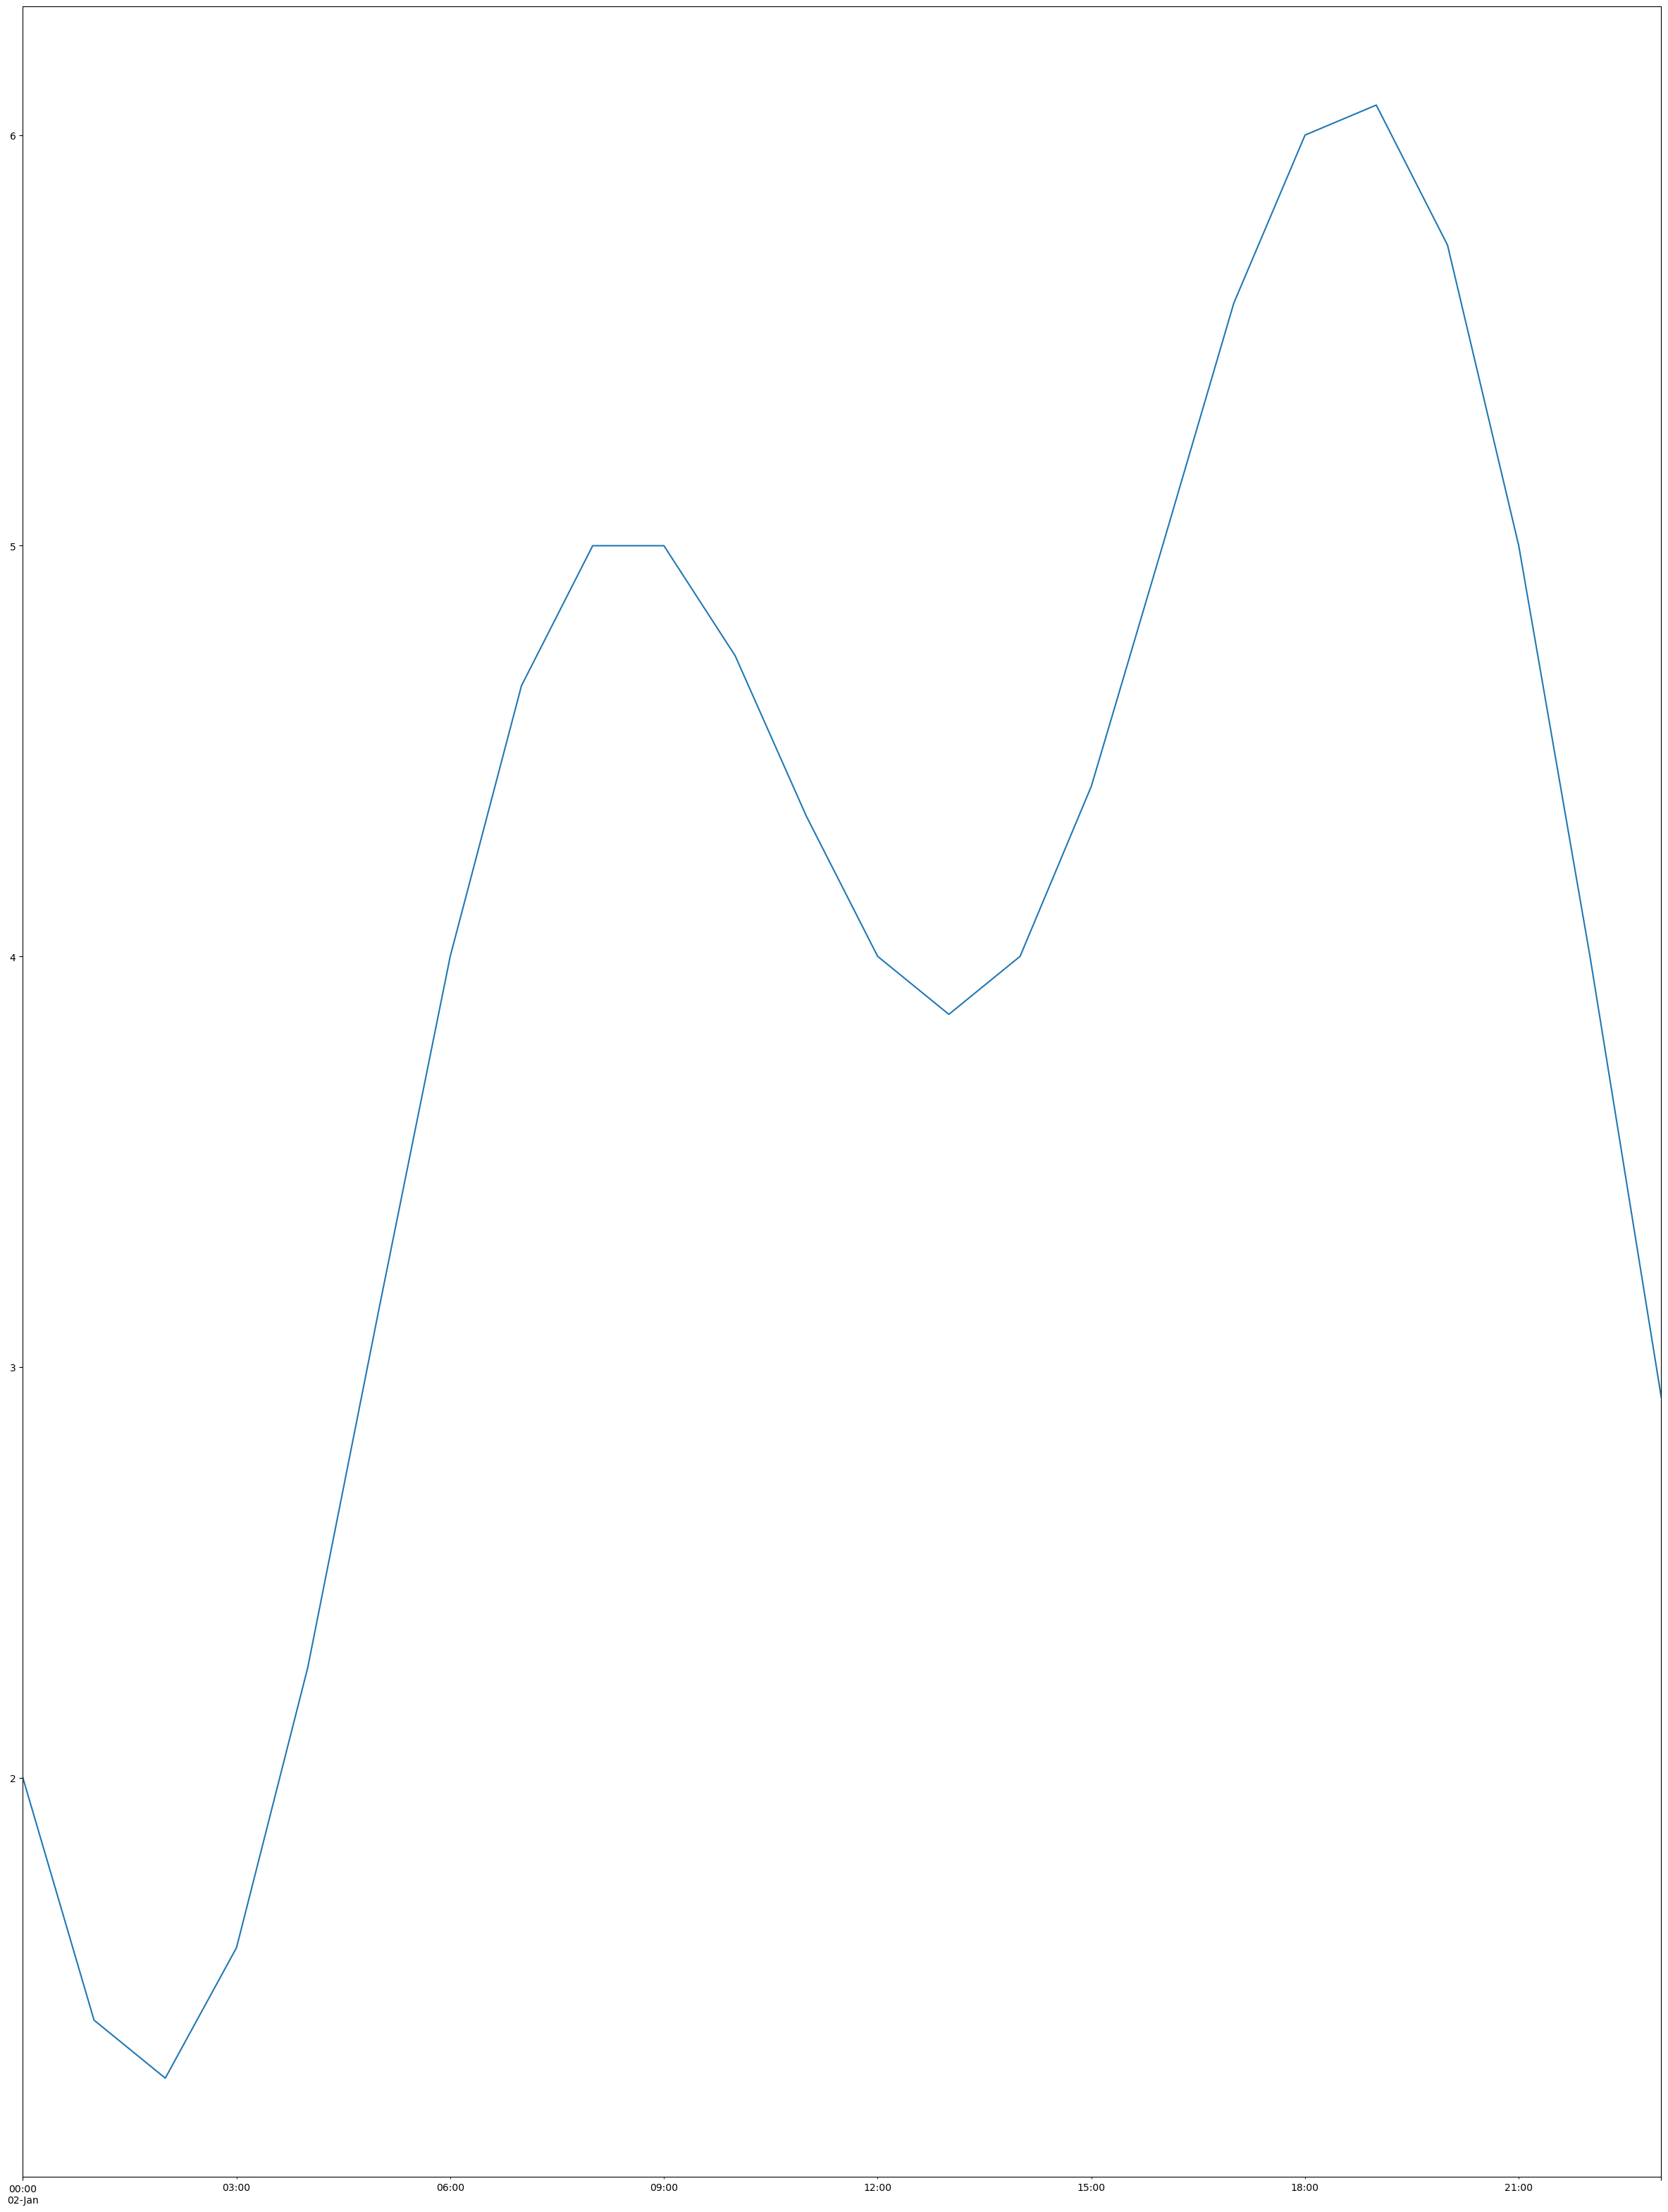

In [314]:
# Visualizing the new variables on hour seasonality
pd.plotting.register_matplotlib_converters()
_ = (1-train.loc['01-02-2023':'01-02-2023', [col for col in train if col.startswith('hour')]]).sum(axis = 1).plot()


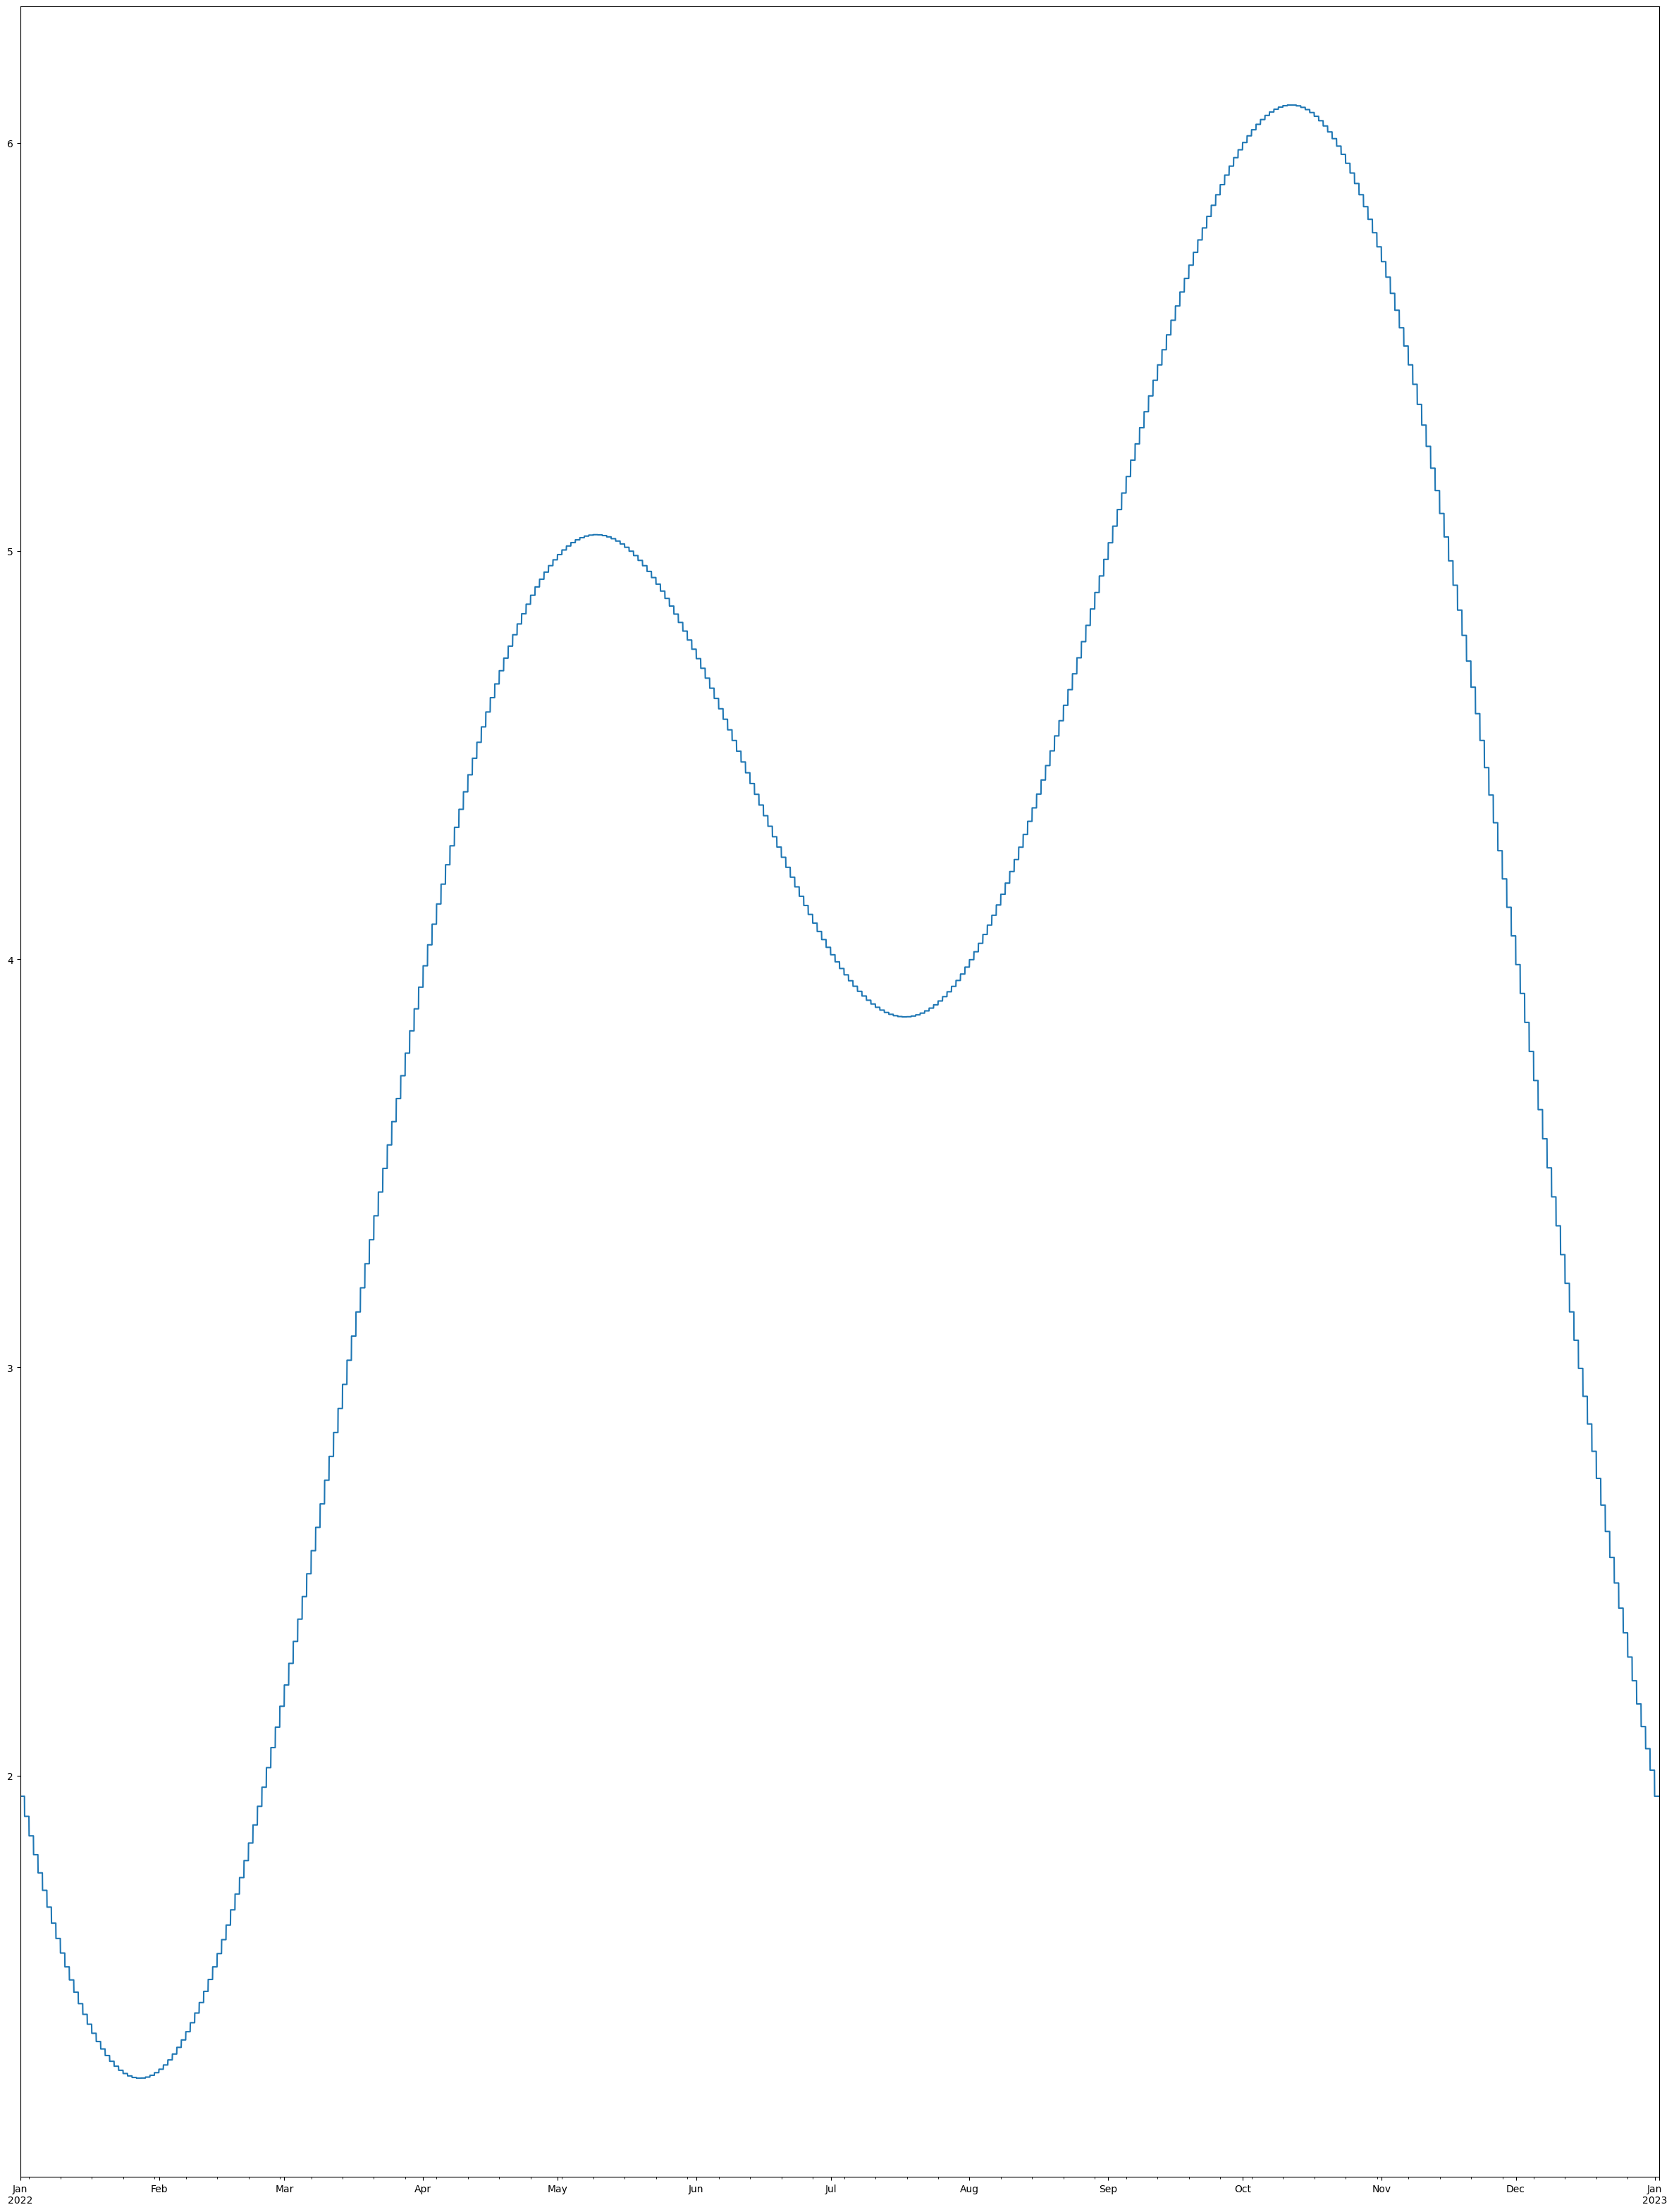

In [315]:
# Visualizing the new variables on year seasonality
_ = (1-train.loc['01-01-2022':'01-01-2023', [col for col in train if col.startswith('year')]]).sum(axis = 1).plot()


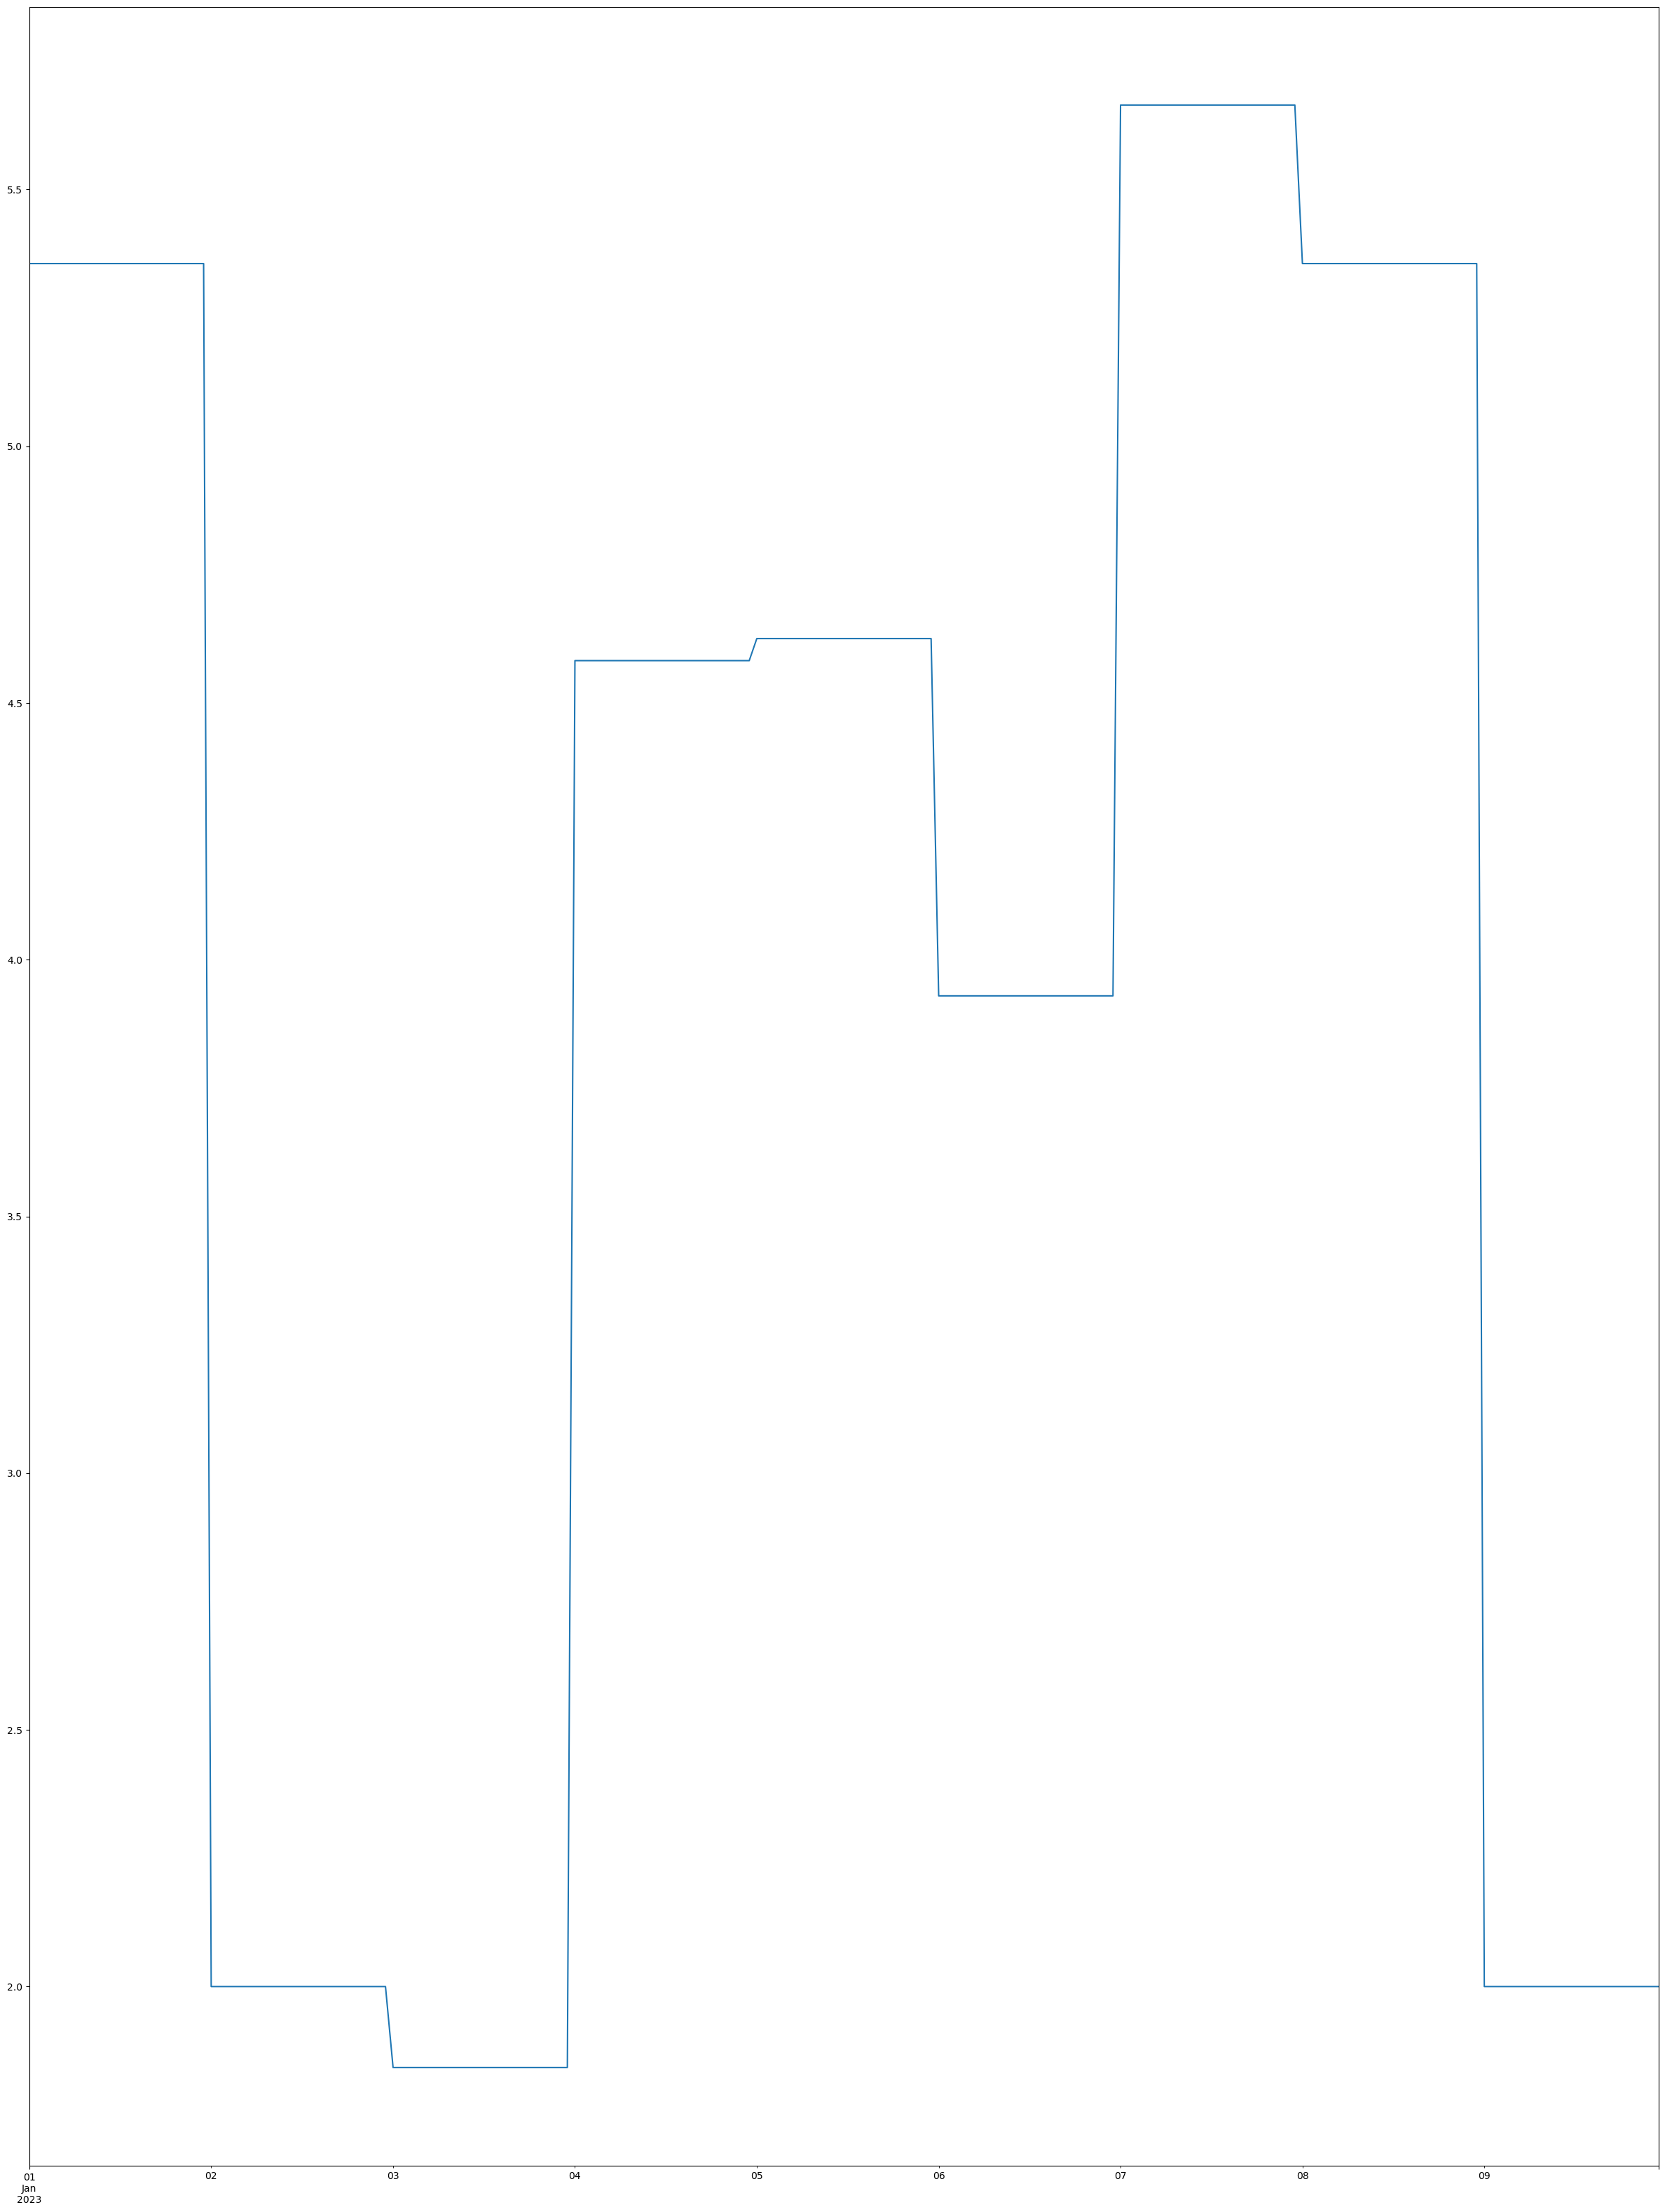

In [316]:
# Visualizing the new variables on week seasonality
_ = (1-train.loc['01-01-2023':'01-09-2023', [col for col in train if col.startswith('week')]]).sum(axis = 1).plot()


In [317]:
# convert the dataset into an optimized data structure called Dmatrix that XGBoost supports and 
# gives it acclaimed performance and efficiency gains
data_dmatrix = xgb.DMatrix(data = train.drop('windspeed', axis=1), label = train['windspeed']) # not used 


In [318]:
# generating the model
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 5, n_estimators = 100, random_state=42)

In [319]:
X_train= train.drop('windspeed', axis=1)
y_train = train['windspeed']

In [320]:
# Fitting the model on the training set
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [321]:
X_test = validation.drop('windspeed', axis=1)

In [322]:
y_test = validation['windspeed']

In [323]:
# Predicting on test set
preds_boost = xg_reg.predict(X_test)

In [272]:
# Creating an empty dict to save all the erros from different models
dict_error = dict()

In [273]:
def error_metrics(y_pred, y_truth, model_name = None, test = True):
    """
    Printing error metrics like RMSE (root mean square error), R2 score, 
    MAE (mean absolute error), MAPE (mean absolute % error). 
    
    y_pred: predicted values of y using the model model_name
    y_truth: observed values of y
    model_name: name of the model used for predictions
    test: if validating on test set, True; otherwise False for training set validation
    
    The function will print the RMSE, R2, MAE and MAPE error metrics for the model_name and also store the results along with 
    model_name in the dictionary dict_error so that we can compare all the models at the end.
    """
    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()
        
    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()
        
    print('\nError metrics for model {}'.format(model_name))
    
    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))
    print("RMSE or Root mean squared error: %.2f" % RMSE)
    
    # Explained variance score: 1 is perfect prediction

    R2 = r2_score(y_truth, y_pred)
    print('Variance score: %.2f' % R2 )

    MAE = mean_absolute_error(y_truth, y_pred)
    print('Mean Absolute Error: %.2f' % MAE)

    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)
    print('Mean Absolute Percentage Error: %.2f %%' % MAPE)
    
    # Appending the error values along with the model_name to the dict
    if test:
        train_test = 'test'
    else:
        train_test = 'train'
    
    #df = pd.DataFrame({'model': model_name, 'RMSE':RMSE, 'R2':R2, 'MAE':MAE, 'MAPE':MAPE}, index=[0])
    name_error = ['model', 'train_test', 'RMSE', 'R2', 'MAE', 'MAPE']
    value_error = [model_name, train_test, RMSE, R2, MAE, MAPE]
    list_error = list(zip(name_error, value_error))
    
    for error in list_error:
        if error[0] in dict_error:
            # append the new number to the existing array at this slot
            dict_error[error[0]].append(error[1])
        else:
            # create a new array in this slot
            dict_error[error[0]] = [error[1]]
    #return(dict_error)

In [279]:
def plot_ts_pred(og_ts, pred_ts, model_name=None, og_ts_opacity = 0.5, pred_ts_opacity = 0.5):
    """
    Plot plotly time series of the original (og_ts) and predicted (pred_ts) time series values to check how our model performs.
    model_name: name of the model used for predictions
    og_ts_opacity: opacity of the original time series
    pred_ts_opacity: opacity of the predicted time series
    """
    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x = og_ts.index, y = np.array(og_ts.values), name = "Observed",
                         line_color = 'deepskyblue', opacity = og_ts_opacity))

    try:
        fig.add_trace(go.Scatter(x = pred_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))
    except: #if predicted values are a numpy array they won't have an index
        fig.add_trace(go.Scatter(x = og_ts.index, y = pred_ts, name = model_name,
                         line_color = 'lightslategrey', opacity = pred_ts_opacity))


    #fig.add_trace(go)
    fig.update_layout(title_text = 'Observed test set vs predicted energy MWH values using {}'.format(model_name),
                  xaxis_rangeslider_visible = True)
    fig.show()

In [324]:
_ = error_metrics(preds_boost, y_test, model_name='XGBoost with Fourier terms', test=True)



Error metrics for model XGBoost with Fourier terms
RMSE or Root mean squared error: 12.12
Variance score: -7.95
Mean Absolute Error: 11.15
Mean Absolute Percentage Error: 38.38 %


In [325]:
_ = error_metrics(xg_reg.predict(X_train), y_train, model_name='XGBoost with Fourier terms', test= False)



Error metrics for model XGBoost with Fourier terms
RMSE or Root mean squared error: 6.78
Variance score: 0.20
Mean Absolute Error: 5.17
Mean Absolute Percentage Error: inf %


In [326]:
plot_ts_pred(y_train, xg_reg.predict(X_train), model_name='XGBoost with Fourier terms on Training set')

In [327]:
plot_ts_pred(y_test, preds_boost, model_name='XGBoost with Fourier terms on Test set')

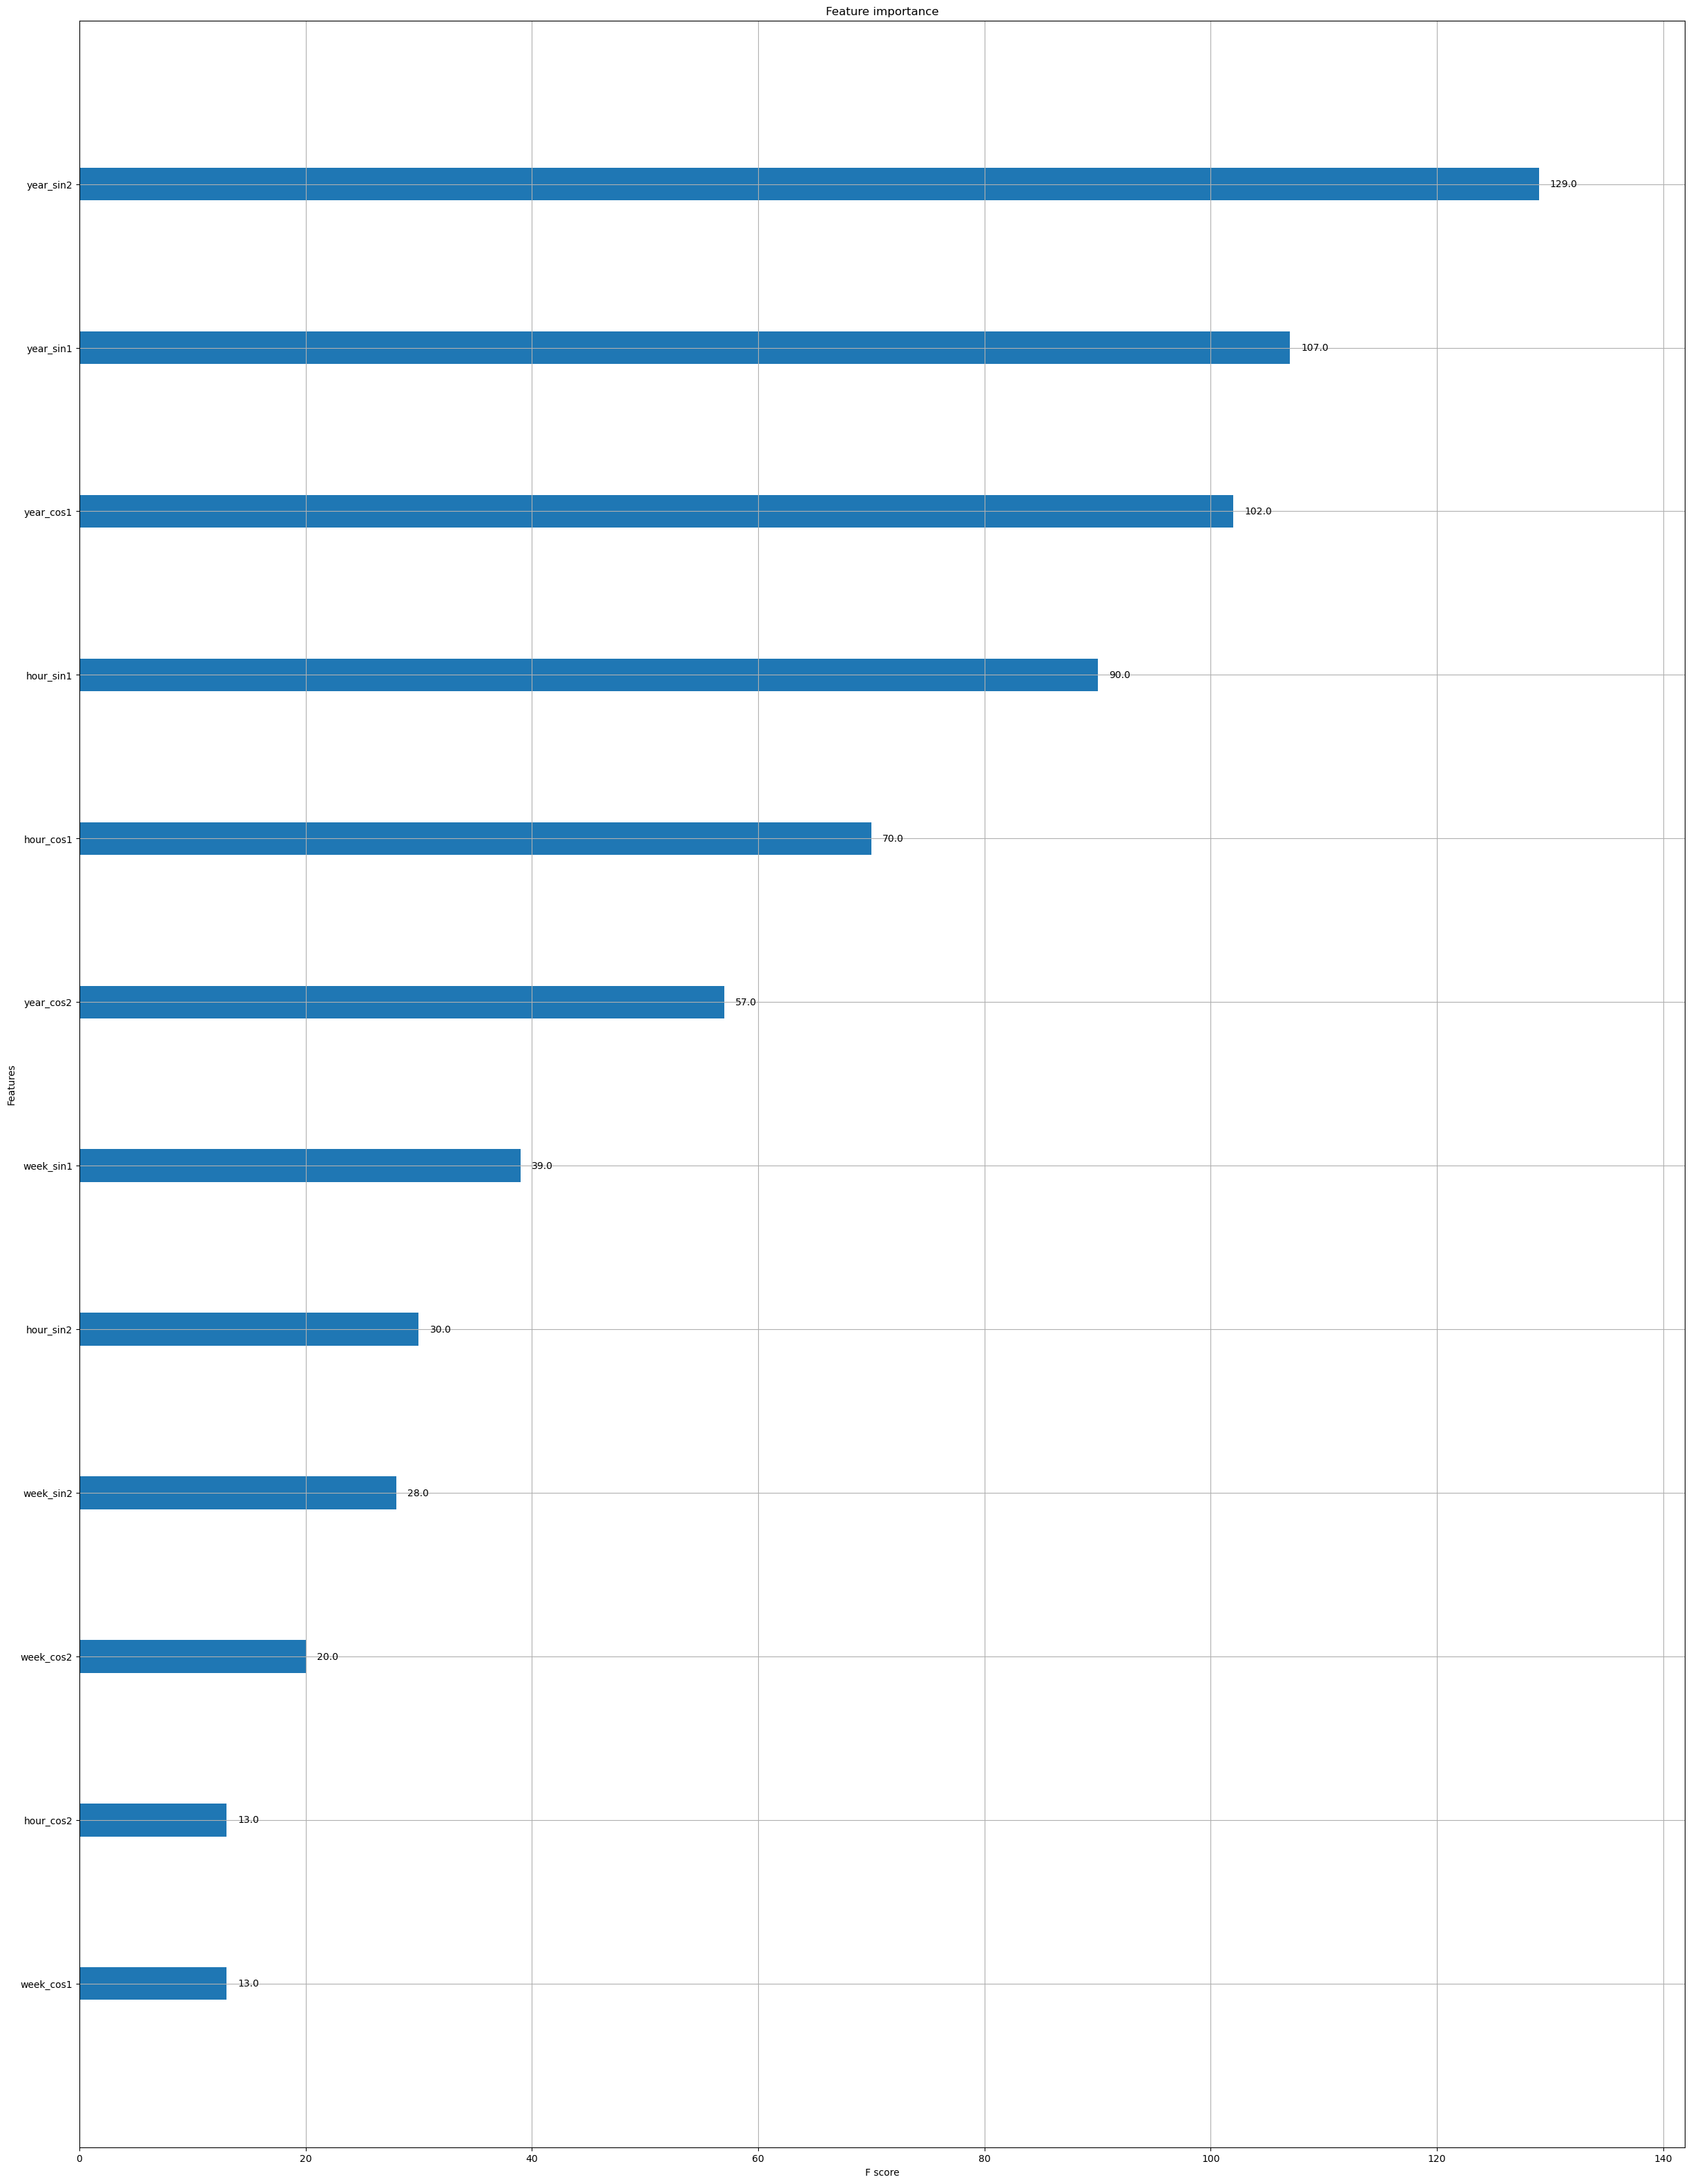

In [328]:
#pd.plotting.register_matplotlib_converters()
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 7]

In [285]:
pip install graphviz

  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/18/79/12d3f468cc67a04d0db640bdd54913e60cd9828e3eada107d330d760d61a/graphviz-0.20.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 583.6 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [289]:
# For plotting the tree
import os
os.environ["PATH"] += os.pathsep + 'Users/ppawar/graphviz-2.38/release/bin'

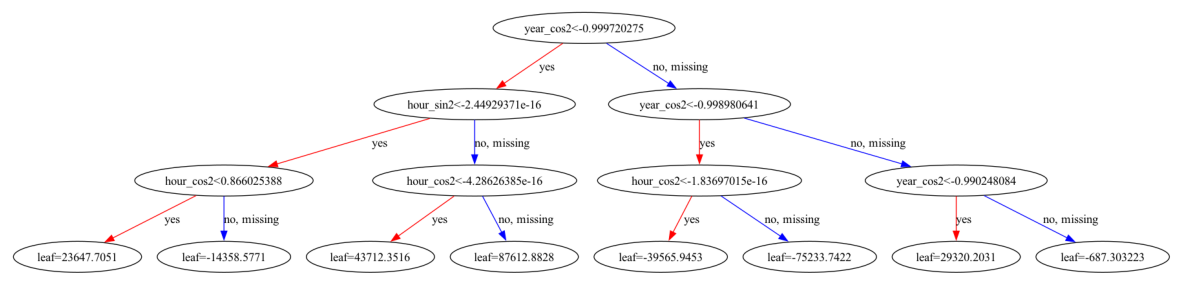

In [291]:
#pd.plotting.register_matplotlib_converters()
xgb.plot_tree(xg_reg,num_trees=98) # Choosing the last few trees because the model optimizes sequentially
plt.rcParams['figure.figsize'] = [30, 40]

## LSTM 2

In [333]:
dataset = pd.read_pickle("colchester_cleaned.pkl")
dataset = dataset['windpower'].to_frame()
# Use only data from 2000-01-01 to 2022-11-31 for the train, for validation use data from 2022-12-01 to 2022-12-31 and for test from 2023-01-01 to 2024-01-05
train_lstm = process_data(dataset.loc['2018-01-01':'2023-12-20'])
validation_lstm = process_data(dataset.loc['2023-12-20':'2023-12-31'])
test_lstm = process_data(dataset.loc['2024-01-01':'2024-01-05'])

<Axes: >

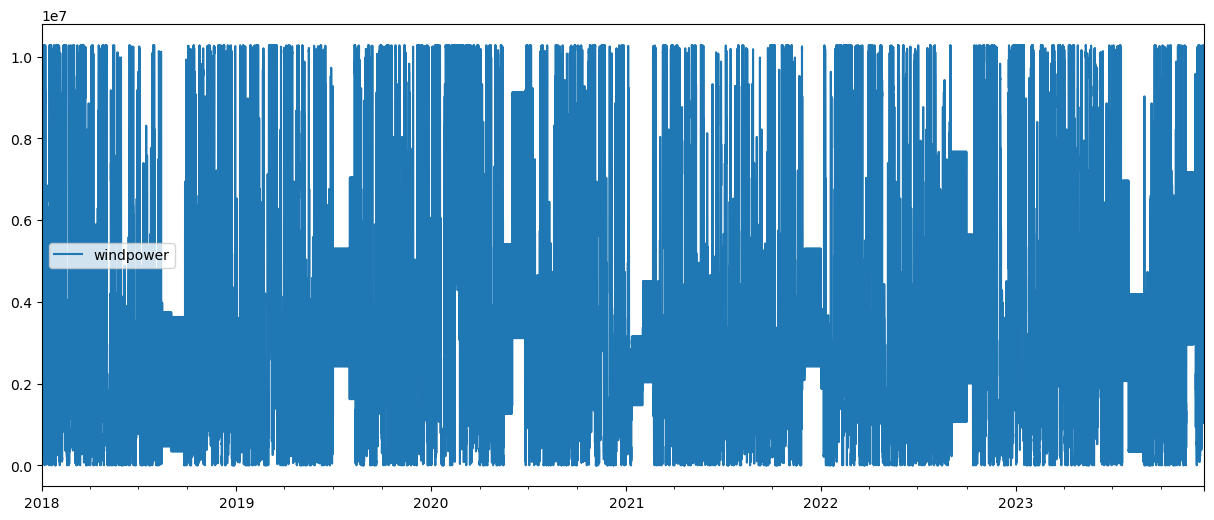

In [330]:
train_lstm.plot(figsize=(15, 6))

<Axes: xlabel='windpower', ylabel='Density'>

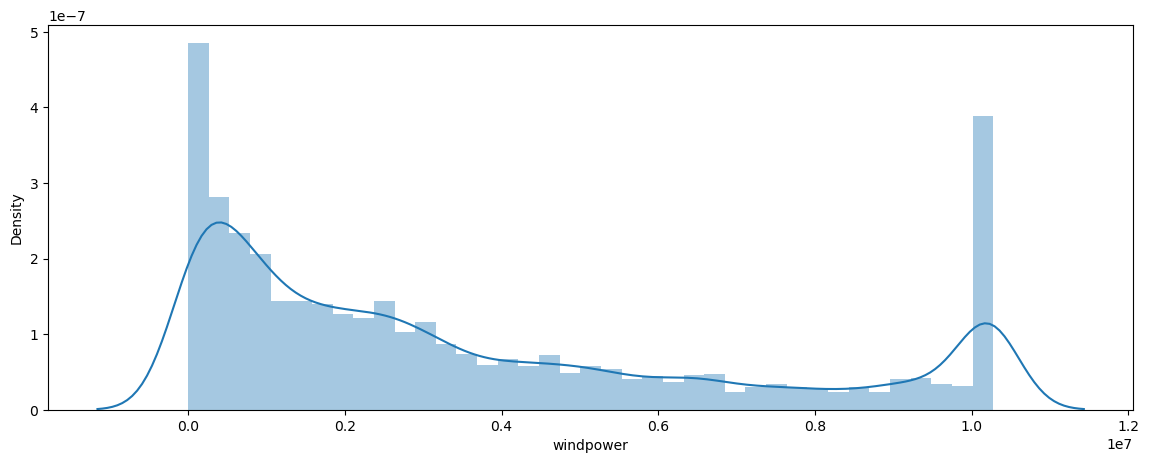

In [335]:
plt.figure(figsize = (14,5))
sns.distplot(train_lstm['windpower'])

In [342]:
def Sequential_Input_LSTM(df, input_sequence):
    df_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_np) - input_sequence):
        row = [a for a in df_np[i:i + input_sequence]]
        X.append(row)
        label = df_np[i + input_sequence]
        y.append(label)
        
    return np.array(X), np.array(y)


n_input = 10      

df_min_model_data = train_lstm['windpower']

X_train, y_train = Sequential_Input_LSTM(df_min_model_data, n_input)

In [345]:
X_test,y_test = Sequential_Input_LSTM(test_lstm['windpower'], n_input)

In [346]:
X_val, y_val = Sequential_Input_LSTM(validation_lstm['windpower'], n_input)

In [347]:
from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam 

In [359]:
n_features = 1                        

model1 = Sequential()

model1.add(InputLayer((n_input,n_features)))
model1.add(LSTM(100, return_sequences = True))     
model1.add(LSTM(100, return_sequences = True))
model1.add(LSTM(50))
model1.add(Dense(8, activation = 'relu'))
model1.add(Dense(1, activation = 'linear'))

model1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 10, 100)           40800     
                                                                 
 lstm_14 (LSTM)              (None, 10, 100)           80400     
                                                                 
 lstm_15 (LSTM)              (None, 50)                30200     
                                                                 
 dense_8 (Dense)             (None, 8)                 408       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 151817 (593.04 KB)
Trainable params: 151817 (593.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [360]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.1), 
               metrics = RootMeanSquaredError())

model1.fit(X_train, y_train, 
           validation_data = (X_val, y_val), 
           epochs = 20, 
           callbacks = [early_stop])

Epoch 1/20


1635/1635 [==============================] - 64s 33ms/step - loss: 17402751352832.0000 - root_mean_squared_error: 4171660.5000 - val_loss: 39643219230720.0000 - val_root_mean_squared_error: 6296286.0000
Epoch 2/20
1635/1635 [==============================] - 48s 30ms/step - loss: 11490863087616.0000 - root_mean_squared_error: 3389817.5000 - val_loss: 35047579058176.0000 - val_root_mean_squared_error: 5920099.5000
Epoch 3/20
1635/1635 [==============================] - 56s 35ms/step - loss: 11472763617280.0000 - root_mean_squared_error: 3387146.7500 - val_loss: 34855721107456.0000 - val_root_mean_squared_error: 5903873.5000
Epoch 4/20
1635/1635 [==============================] - 39s 24ms/step - loss: 11473127473152.0000 - root_mean_squared_error: 3387200.5000 - val_loss: 34964489895936.0000 - val_root_mean_squared_error: 5913078.0000
Epoch 5/20
1635/1635 [==============================] - 39s 24ms/step - loss: 11472799268864.0000 - root_mean_squared_error: 3387152.0000 - val_loss: 34445

<Axes: >

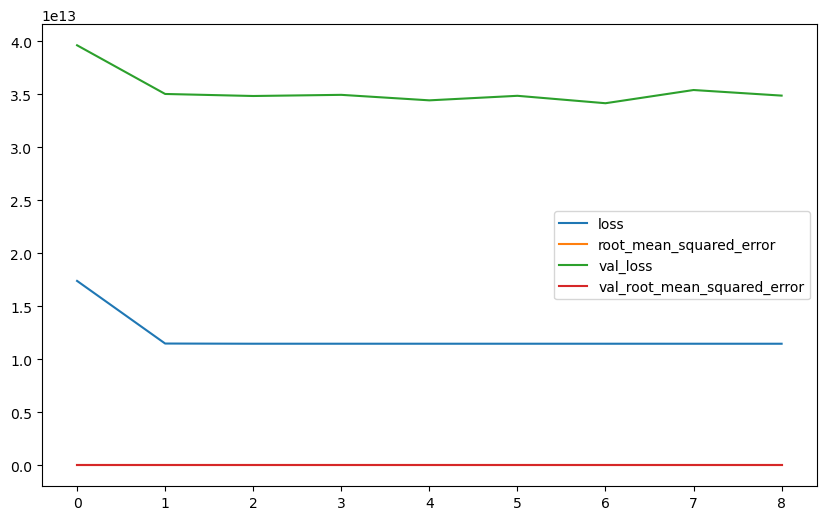

In [361]:
losses_df1 = pd.DataFrame(model1.history.history)

losses_df1.plot(figsize = (10,6))

In [351]:
model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.001), 
               metrics = RootMeanSquaredError())

history2=model1.fit(X_train, y_train, 
           validation_data = (X_val, y_val), 
           epochs = 10, 
           callbacks = [early_stop])

Epoch 1/10
1635/1635 [==============================] - 53s 28ms/step - loss: 24149705621504.0000 - root_mean_squared_error: 4914235.0000 - val_loss: 84526608941056.0000 - val_root_mean_squared_error: 9193835.0000
Epoch 2/10
1635/1635 [==============================] - 53s 32ms/step - loss: 24124353150976.0000 - root_mean_squared_error: 4911655.0000 - val_loss: 84458023682048.0000 - val_root_mean_squared_error: 9190105.0000
Epoch 3/10
1635/1635 [==============================] - 54s 33ms/step - loss: 24094317740032.0000 - root_mean_squared_error: 4908596.5000 - val_loss: 84378516455424.0000 - val_root_mean_squared_error: 9185778.0000
Epoch 4/10
1635/1635 [==============================] - 56s 34ms/step - loss: 24059997847552.0000 - root_mean_squared_error: 4905099.0000 - val_loss: 84288766738432.0000 - val_root_mean_squared_error: 9180891.0000
Epoch 5/10
1635/1635 [==============================] - 55s 33ms/step - loss: 24021695463424.0000 - root_mean_squared_error: 4901193.5000 - val_

In [352]:
model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.005), 
               metrics = RootMeanSquaredError())

history3=model1.fit(X_train, y_train, 
           validation_data = (X_val, y_val), 
           epochs = 10, 
           callbacks = [early_stop])

Epoch 1/10
1635/1635 [==============================] - 55s 30ms/step - loss: 23573104164864.0000 - root_mean_squared_error: 4855214.0000 - val_loss: 82645899804672.0000 - val_root_mean_squared_error: 9090979.0000
Epoch 2/10
1635/1635 [==============================] - 51s 31ms/step - loss: 23151404646400.0000 - root_mean_squared_error: 4811590.5000 - val_loss: 81438896553984.0000 - val_root_mean_squared_error: 9024350.0000
Epoch 3/10
1635/1635 [==============================] - 49s 30ms/step - loss: 22626500083712.0000 - root_mean_squared_error: 4756732.0000 - val_loss: 79978842554368.0000 - val_root_mean_squared_error: 8943089.0000
Epoch 4/10
1635/1635 [==============================] - 50s 30ms/step - loss: 22016551813120.0000 - root_mean_squared_error: 4692180.0000 - val_loss: 78293151776768.0000 - val_root_mean_squared_error: 8848342.0000
Epoch 5/10
1635/1635 [==============================] - 50s 31ms/step - loss: 21337129091072.0000 - root_mean_squared_error: 4619213.0000 - val_

In [354]:
model1.compile(loss = MeanSquaredError(), 
               optimizer = Adam(learning_rate = 0.01), 
               metrics = RootMeanSquaredError())

history3=model1.fit(X_train, y_train, 
           validation_data = (X_val, y_val), 
           epochs = 10, 
           callbacks = [early_stop])

Epoch 1/10
1635/1635 [==============================] - 86s 46ms/step - loss: 16092811493376.0000 - root_mean_squared_error: 4011584.7500 - val_loss: 58962732908544.0000 - val_root_mean_squared_error: 7678719.5000
Epoch 2/10
1635/1635 [==============================] - 55s 34ms/step - loss: 14561263484928.0000 - root_mean_squared_error: 3815922.2500 - val_loss: 53305547948032.0000 - val_root_mean_squared_error: 7301065.0000
Epoch 3/10
1635/1635 [==============================] - 56s 35ms/step - loss: 13282975940608.0000 - root_mean_squared_error: 3644581.7500 - val_loss: 47825056432128.0000 - val_root_mean_squared_error: 6915566.0000
Epoch 4/10
1635/1635 [==============================] - 75s 46ms/step - loss: 12352582844416.0000 - root_mean_squared_error: 3514624.2500 - val_loss: 42977825128448.0000 - val_root_mean_squared_error: 6555747.5000
Epoch 5/10
1635/1635 [==============================] - 56s 34ms/step - loss: 11798037135360.0000 - root_mean_squared_error: 3434827.0000 - val_

In [356]:
# save the model
save_model(model1, "LSTM_Models/lstm_univariate.h5")

# load the model
model1 = load_model('LSTM_Models/lstm_univariate.h5')

In [362]:
test_predictions1 = model1.predict(X_test).flatten()


X_test_list = []
for i in range(len(X_test)):
    X_test_list.append(X_test[i][0])
    

test_predictions_df1 = pd.DataFrame({'X_test':list(X_test_list), 
                                    'LSTM Prediction':list(test_predictions1)})

3/3 [==============================] - 2s 7ms/step


<Axes: >

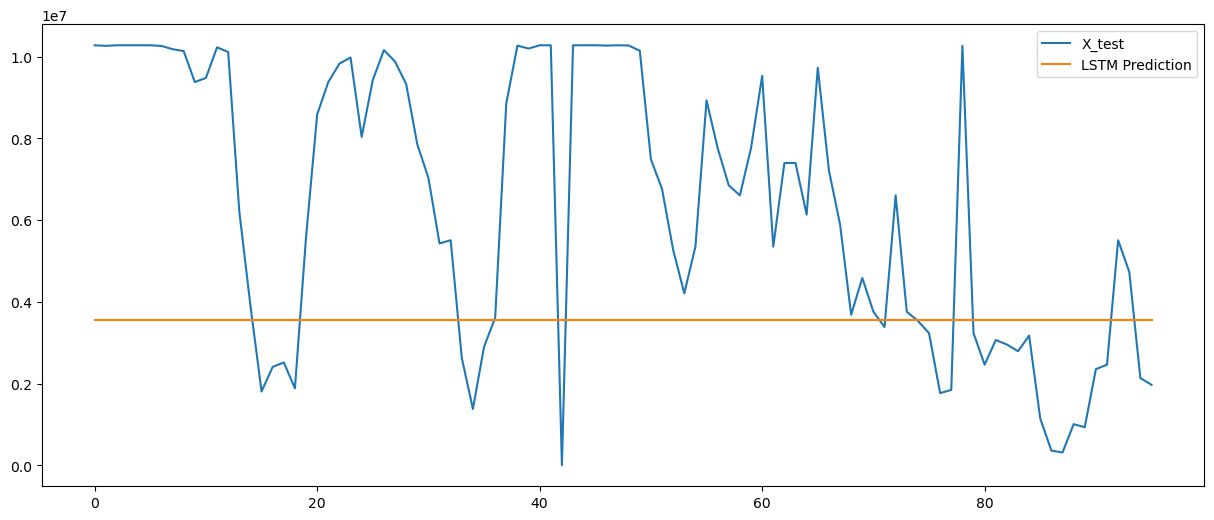

In [363]:
test_predictions_df1.plot(figsize = (15,6))